In [1]:
import sys
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
plt.style.use(mplhep.style.CMS)
import matplotlib.font_manager
mpl.rcParams.update(
    {'font.size': 24,
     'font.family': 'sans-serif',
     'legend.fontsize': 24,
     'axes.labelsize': 24,
     'axes.labelpad': 10,
     'xtick.labelsize': 22,
     'ytick.labelsize': 22 
    }
    )

mpl.rcParams

['/cvmfs/sft.cern.ch/lcg/releases/condor/8.9.11-50a33/x86_64-centos7-gcc11-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/srv/dask/lib', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python39.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/lib-dynload', '/eos/user/m/malvesga/.local/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-op

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
   

In [2]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

# norm_to_1fb = True
norm_to_1fb = False

# lepton_type = 'muon'
lepton_type = 'electron'

# data_sample = '2017'
data_sample = '2018'

save_figures = True

bkg_MC_mix_protons = True

# run_tables = False

{'muon': {'2017B': 4.799881474, '2017C1': 5.785813941, '2017C2': 3.786684323, '2017D': 4.247682053, '2017E': 9.312832062, '2017F1': 1.738905587, '2017F2': 8.125575961, '2017F3': 3.674404546}, 'electron': {'2017B': 4.594096155565198, '2017C1': 5.521298099245362, '2017C2': 3.6135646891210857, '2017D': 4.0518639103567, '2017E': 8.906848461089172, '2017F1': 1.6584516422062712, '2017F2': 7.749629938012412, '2017F3': 3.504400870870218}}
Luminosity 2017 muon: 41.471779946999995
Luminosity 2017 electron: 39.60015376646642
{'muon': {'2018A': 12.103512482, '2018B1': 6.3798061, '2018B2': 0.40141386, '2018C': 6.524227381, '2018D1': 19.877577, '2018D2': 10.414449}, 'electron': {'2018A': 12.103189833, '2018B1': 6.379806, '2018B2': 0.40141386, '2018C': 6.527251329, '2018D1': 19.876804, '2018D2': 10.414449}}
Luminosity 2018 muon: 55.700985822999996
Luminosity 2018 electron: 55.702914022


### Event selection

In [3]:
def tau21_ddt_calculation(df, lepton_type, label_jet=None):
    
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    jet0_tau21_ = ( df.loc[ :, "jet0_tau2"] / df.loc[ :, "jet0_tau1"] )
    
    M_ = 0. ##M is the slope of the tau21 versus rhoprime1
    rhoprime1_ = np.log((((df.loc[ :, "jet0_corrmass" + label_jet_])**2)/(df.loc[ :, "jet0_pt" + label_jet_])))
    if lepton_type == 'muon':
        #M_ = -0.06549078537121121 
        M_ = -0.06985584011450555
    if lepton_type == 'electron':
        #M_ = -0.05984253738963618    
        M_ = -0.057877831836395534    
    jet0_tau21_ddt_ = jet0_tau21_ - (M_*rhoprime1_)
    
    return jet0_tau21_, rhoprime1_, jet0_tau21_ddt_

In [4]:
def back_to_back_variables(df, lepton_type):
        
    lepton_var_phi_ = ""
    lepton_var_eta_ = ""
    if lepton_type == 'muon':
        lepton_var_phi_ = "muon0_phi"
        lepton_var_eta_ = "muon0_eta"
    elif lepton_type == 'electron':
        lepton_var_phi_ = "electron0_phi"
        lepton_var_eta_ = "electron0_eta"
        
    deltaPhi_jet_lep_ = ( df.loc[ :, "jet0_phi"] - df.loc[ :, lepton_var_phi_ ] )
    msk_dphi_ = ( deltaPhi_jet_lep_ < -np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_lep_ >= np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaEta_jet_lep_ = ( df.loc[ :, "jet0_eta"] - df.loc[ :, lepton_var_eta_ ] )
    deltaR_jet_lep_ = np.sqrt( ( deltaPhi_jet_lep_ ) ** 2 + ( deltaEta_jet_lep_ ) ** 2 )
    
    deltaPhi_jet_met_ = ( df.loc[ :, "jet0_phi"] - df.loc[ :, "met_phi"] )
    msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaPhi_jet_Wlep_ = ( df.loc[ :, "jet0_phi"] - df.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi
    
    return deltaR_jet_lep_, deltaPhi_jet_met_, deltaPhi_jet_Wlep_

In [5]:
def select_events( df_events, lepton_type, max_num_tracks = 4, label_jet=None, label_muon=None, label_electron=None ):

    max_num_tracks_ = max_num_tracks
    
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    label_muon_ = "_nom"
    if label_muon is not None: label_muon_ = label_muon
        
    label_electron_ = "_nom"
    if label_electron is not None: label_electron_ = label_electron
        
    label_WLep_ = "_nom"
    if label_muon is not None:
        label_WLep_ = label_muon
    elif label_electron is not None:
        label_WLep_ = label_electron
        
    label_WW_ = "_nom"
    if label_jet is not None:
        label_WW_ = label_jet
    elif label_muon is not None:
        label_WW_ = label_muon
    elif label_electron is not None:
        label_WW_ = label_electron
        
    label_xiCMS_ = "_nom"
    if label_jet is not None:
        label_xiCMS_ = label_jet
    elif label_muon is not None:
        label_xiCMS_ = label_muon
    elif label_electron is not None:
        label_xiCMS_ = label_electron
    
    lepton_var_phi_ = ""
    lepton_var_eta_ = ""
    if lepton_type == 'muon':
        lepton_var_phi_ = "muon0_phi"
        lepton_var_eta_ = "muon0_eta"
    elif lepton_type == 'electron':
        lepton_var_phi_ = "electron0_phi"
        lepton_var_eta_ = "electron0_eta"
        
#     deltaPhi_jet_lep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, lepton_var_phi_ ] )
#     msk_dphi_ = ( deltaPhi_jet_lep_ < -np.pi )
#     deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] + 2*np.pi
#     msk_dphi_ = ( deltaPhi_jet_lep_ >= np.pi )
#     deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] - 2*np.pi
    
#     deltaEta_jet_lep_ = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, lepton_var_eta_ ] )
#     deltaR_jet_lep_ = np.sqrt( ( deltaPhi_jet_lep_ ) ** 2 + ( deltaEta_jet_lep_ ) ** 2 )
    
#     deltaPhi_jet_met_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
#     msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
#     deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
#     msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
#     deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
#     deltaPhi_jet_Wlep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
#     msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
#     deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
#     msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
#     deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaR_jet_lep_, deltaPhi_jet_met_, deltaPhi_jet_Wlep_ = back_to_back_variables( df_events, lepton_type )
    df_events["deltaR_jet_lep"] = deltaR_jet_lep_
    df_events["deltaPhi_jet_met"] = deltaPhi_jet_met_
    df_events["deltaPhi_jet_Wlep"] = deltaPhi_jet_Wlep_
    
    jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_events, lepton_type )
    
    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    
    msk_lep_ = None
    if lepton_type == 'muon':
        msk_lep_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                     ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    elif lepton_type == 'electron':
        msk_lep_ = ( ( df_events.loc[ :, "electron0_pt" + label_electron_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "electron0_eta"] ) <= 2.4 ) )
        
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 220.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    
    msk_jet_lep_ = ( deltaR_jet_lep_ >= np.pi/2 )
    
    if lepton_type == 'muon':
        msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    elif lepton_type == 'electron':
        msk_met_ = ( df_events.loc[ :, "met"] >= 100.0 )    
    
    msk_jet_met_ = ( np.abs( deltaPhi_jet_met_ ) >= 2.0 )

    #### sideband studies 
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )

    msk_tau21_       = ( jet0_tau21_ddt_ <= 0.7 )
#     msk_tau21_       = ( jet0_tau21_ <= 0.6 )
    
    ####
    
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )

    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" + label_xiCMS_ ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" + label_xiCMS_ ] <= 0.20 ) )
    
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    
    msk_jet_Wlep_ = ( np.abs( deltaPhi_jet_Wlep_ ) >= 2.5 )
    
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )
    
    msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= max_num_tracks_ )
    
    msk_nprotons_ = ( ( df_events.loc[ :, "nprotons_arm0" ] <= 3 ) & ( df_events.loc[ :, "nprotons_arm1" ] <= 3 ) )
    
    ##masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
    ##           msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
    ##           msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    
    masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_nprotons_ ]
    
    lepton_sel_name_ = ""
    jet_lepton_sel_name_ = ""
    if lepton_type == 'muon':
        lepton_sel_name_ = "Muon"
        jet_lepton_sel_name_ = "Jet_Muon"
    elif lepton_type == 'electron':
        lepton_sel_name_ = "Electron"
        jet_lepton_sel_name_ = "Jet_Electron"
        
    ##selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
    ##                    "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
    ##                    "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    
    selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
                        "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
                        "WLeptonic", "MWW", "NProtons" ]
    
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_

### Signal

In [6]:
load_signal = True

labels_signals = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_signals = [ "GGToWW-AQGC-2017-muon-A0W1e-6", "GGToWW-AQGC-2017-muon-A0W2e-6", "GGToWW-AQGC-2017-muon-A0W5e-6" ]
    elif lepton_type == 'electron':
        labels_signals = [ "GGToWW-AQGC-2017-electron-A0W1e-6", "GGToWW-AQGC-2017-electron-A0W2e-6", "GGToWW-AQGC-2017-electron-A0W5e-6" ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_signals = [ "GGToWW-AQGC-2018-muon-A0W1e-6", "GGToWW-AQGC-2018-muon-A0W2e-6", "GGToWW-AQGC-2018-muon-A0W5e-6" ]
    elif lepton_type == 'electron':
        labels_signals = [ "GGToWW-AQGC-2018-electron-A0W1e-6", "GGToWW-AQGC-2018-electron-A0W2e-6", "GGToWW-AQGC-2018-electron-A0W5e-6" ]
    
df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}
df_signals_protons_multiRP_events_nTracks40 = {}
df_signals_protons_multiRP_pre_sel_events = {}
if load_signal:
#     base_path_ = "output"
    base_path_ = "output-final"
    #base_path_ = "output_new"
    for label_ in labels_signals:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )           
            df_counts_signals[ label_ ] = store_[ "counts" ]
            df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
            df_signals_protons_multiRP_pre_sel_events[ label_ ] = store_[ "events_multiRP" ]
            
            df_signals__ = df_signals_protons_multiRP_pre_sel_events[ label_ ]
            jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_signals__, lepton_type )
            df_signals__["jet0_tau21"] = jet0_tau21_
            df_signals__["jet0_tau21_ddt"] = jet0_tau21_ddt_
            print ( df_signals__.shape[0] )
            
            df_signals_protons_multiRP_events__, selection_keys__, selections__ = select_events( df_signals__, lepton_type )
            print ( df_signals_protons_multiRP_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events[ label_ ] = {}
            df_signals_protons_multiRP_events[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events__
            
            df_signals_protons_multiRP_events_nTracks40__, selection_keys__, selections__ = select_events( df_signals__, lepton_type, max_num_tracks=40 )
            print ( df_signals_protons_multiRP_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events_nTracks40[ label_ ] = {}
            df_signals_protons_multiRP_events_nTracks40[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events_nTracks40__

GGToWW-AQGC-2018-electron-A0W1e-6
['/counts', '/events_multiRP', '/protons_multiRP']
806
267
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'All': 806, 'Electron': 806, 'Jet': 728, 'Jet_Electron': 728, 'MET': 450, 'Jet_MET': 446, 'PrunedMass': 322, 'Tau21': 282, 'BJet_Veto': 282, 'Xi_CMS': 279, 'WLeptonic': 273, 'MWW': 273, 'NProtons': 267}
267
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'All': 806, 'Electron': 806, 'Jet': 728, 'Jet_Electron': 728, 'MET': 450, 'Jet_MET': 446, 'PrunedMass': 322, 'Tau21': 282, 'BJet_Veto': 282, 'Xi_CMS': 279, 'WLeptonic': 273, 'MWW': 273, 'NProtons': 267}
GGToWW-AQGC-2018-electron-A0W2e-6
['/counts', '/events_multiRP', '/protons_multiRP']
1374
620
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MW

In [7]:
label_ref_ = ""
if data_sample == '2017':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2017-muon-A0W2e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2017-electron-A0W2e-6'
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2018-muon-A0W1e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2018-electron-A0W1e-6'
df_signals_protons_multiRP_events[ label_ref_ ]

{'_nom':                                                 crossingAngle  betaStar  \
 run lumiblock event hash_id              slice                            
 1   1         2     7177656579901433728  0              152.0       0.4   
               7     17594879696327020117 0              152.0       0.4   
               22    9608868807681560549  0              152.0       0.4   
               48    1373565813609640166  0              152.0       0.4   
               29    10498469570915629771 0              152.0       0.4   
 ...                                                       ...       ...   
               7     1194759547475740112  0              152.0       0.4   
               27    6895563007181545735  0              152.0       0.4   
               25    15264549018643777190 0              152.0       0.4   
               12    15785121003696745026 0              152.0       0.4   
               10    16357079570595832897 0              152.0       0.4   
 
  

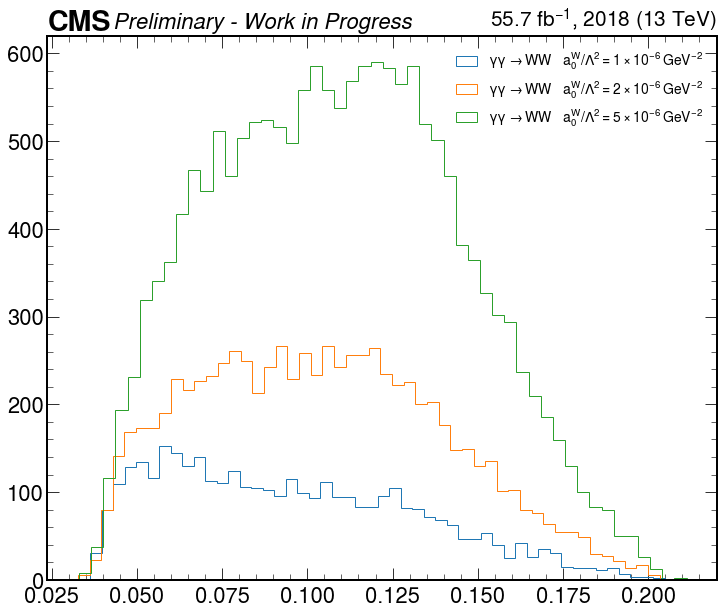

In [8]:
labels_samples = {
    "GGToWW-AQGC-A0W5e-7": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-7} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 1 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 2 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-6} \,\rm{GeV}^{-2}$"
}
labels_samples[ "GGToWW-AQGC-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]

if load_signal:
    fig = plt.figure( figsize=(12,10) )
    for label_ in labels_signals: 
        plt.hist( df_signals_protons_multiRP_index[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
    mplhep.cms.label('Preliminary - Work in Progress', data=True, lumi=55.7, year=2018, loc=0, fontsize=22)    
    plt.legend( loc='best', fontsize=14 )

In [9]:
import json
samples_info = None
if data_sample == '2017':
    samples_info = json.load( open( 'samples_info_2017.json' ) )
elif data_sample == '2018':
#     samples_info = json.load( open( 'samples_info_2018.json' ) )
#     samples_info = json.load( open( 'samples_info_UL.json' ) )
    samples_info = json.load( open( 'samples_info_UL18_XSDB.json' ) )
samples_info

{'FPMC_WW_bSM_13tev_a0w_1e-7_aCw_0_semi_pt0': [130939.0,
  0.01766328483,
  1.0,
  6],
 'FPMC_WW_bSM_13tev_a0w_2e-7_aCw_0_semi_pt0': [131183.0,
  0.01776035257,
  1.0,
  6],
 'FPMC_WW_bSM_13tev_a0w_5e-7_aCw_0_semi_pt0': [131046.0, 0.0181627419, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0': [130973.0, 0.0196156363, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0': [131203.0,
  0.02544316479,
  1.0,
  6],
 'FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0': [131351.0, 0.0657918945, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_5e-7_semi_pt0': [131205.0,
  0.01773472225,
  1.0,
  6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_1e-6_semi_pt0': [131474.0,
  0.01790024426,
  1.0,
  6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_2e-6_semi_pt0': [131467.0,
  0.01836002257,
  1.0,
  6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_5e-6_semi_pt0': [131370.0,
  0.02134582041,
  1.0,
  6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_1e-5_semi_pt0': [131582.0,
  0.03178985067,
  1.0,
  6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_2e-5_semi_pt0': [131524.0,
  0.072

In [10]:
lumi_periods = None
if data_sample == '2017':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2017[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2017[ 'electron' ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2018[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2018[ 'electron' ]
    
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
if data_sample == '2017':
    if lepton_type == 'muon':
        sample_names[ "GGToWW-AQGC-2017-muon-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-muon-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-muon-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"
    if lepton_type == 'electron':
        sample_names[ "GGToWW-AQGC-2017-electron-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-electron-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-electron-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"
elif data_sample == '2018':
    if lepton_type == 'muon':
        sample_names[ "GGToWW-AQGC-2018-muon-A0W1e-6" ] = "FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-muon-A0W2e-6" ] = "FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-muon-A0W5e-6" ] = "FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0"
    if lepton_type == 'electron':
        sample_names[ "GGToWW-AQGC-2018-electron-A0W1e-6" ] = "FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-electron-A0W2e-6" ] = "FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-electron-A0W5e-6" ] = "FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0"
    
norm_factors = {}
for label_ in labels_signals:
    print ( label_ )
    print ( samples_info[ sample_names[ label_ ] ] )
    sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names[ label_ ] ]
    sample_cross_section_ = sample_cross_section_ * sel_eff_
    if norm_to_1fb:
        sample_cross_section_ = 1.e-03
#     if data_sample == '2018':
#         sample_cross_section_ *= ( 0.14271*(1.174) )
    print ( sample_cross_section_ )
    norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( norm_factors[ label_ ] )
    norm_factors_product_ = np.product( norm_factors[ label_ ] )
#     df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    df_signals_protons_multiRP_events[ label_ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_

55.702914022
GGToWW-AQGC-2018-electron-A0W1e-6
[130973.0, 0.0196156363, 1.0, 6]
0.0196156363
[4.25300742e-04 1.96156363e+01 1.00000000e+00]
GGToWW-AQGC-2018-electron-A0W2e-6
[131203.0, 0.02544316479, 1.0, 6]
0.02544316479
[4.24555186e-04 2.54431648e+01 1.00000000e+00]
GGToWW-AQGC-2018-electron-A0W5e-6
[131351.0, 0.0657918945, 1.0, 6]
0.0657918945
[4.24076817e-04 6.57918945e+01 1.00000000e+00]


/tmp/ipykernel_610/3435712407.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signals_protons_multiRP_events[ label_ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
/tmp/ipykernel_610/3435712407.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signals_protons_multiRP_events[ label_ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
/tmp/ipykernel_610/3435712407.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

### Background

### Load and select events

In [11]:
if not bkg_MC_mix_protons: 
    labels_background = []
    fileNames_bkg = {}
    resample_factor = 50
    if data_sample == '2017':
        if lepton_type == 'muon':
            labels_background = [
                "data-random-resample_50-single-arm-muon-2017B",
                "data-random-resample_50-single-arm-muon-2017C",
                "data-random-resample_50-single-arm-muon-2017D",
                "data-random-resample_50-single-arm-muon-2017E",
                "data-random-resample_50-single-arm-muon-2017F"
            ]
            fileNames_bkg = {
                "data-random-resample_50-single-arm-muon-2017B": "data-store-data-random-resample_50-single-arm-2017B.h5",
                "data-random-resample_50-single-arm-muon-2017C": "data-store-data-random-resample_50-single-arm-2017C.h5",
                "data-random-resample_50-single-arm-muon-2017D": "data-store-data-random-resample_50-single-arm-2017D.h5",
                "data-random-resample_50-single-arm-muon-2017E": "data-store-data-random-resample_50-single-arm-2017E.h5",
                "data-random-resample_50-single-arm-muon-2017F": "data-store-data-random-resample_50-single-arm-2017F.h5"
            }
        elif lepton_type == 'electron':
            labels_background = [
                "data-random-resample_50-single-arm-electron-2017B",
                "data-random-resample_50-single-arm-electron-2017C",
                "data-random-resample_50-single-arm-electron-2017D",
                "data-random-resample_50-single-arm-electron-2017E",
                "data-random-resample_50-single-arm-electron-2017F"
            ]
            fileNames_bkg = {
                "data-random-resample_50-single-arm-electron-2017B": "data-store-data-random-resample_50-single-arm-electron-2017B.h5",
                "data-random-resample_50-single-arm-electron-2017C": "data-store-data-random-resample_50-single-arm-electron-2017C.h5",
                "data-random-resample_50-single-arm-electron-2017D": "data-store-data-random-resample_50-single-arm-electron-2017D.h5",
                "data-random-resample_50-single-arm-electron-2017E": "data-store-data-random-resample_50-single-arm-electron-2017E.h5",
                "data-random-resample_50-single-arm-electron-2017F": "data-store-data-random-resample_50-single-arm-electron-2017F.h5"
            }
    elif data_sample == '2018':
        if lepton_type == 'muon':
            labels_background = [
                "data-random-resample_50-2018-muon-2018A",
                "data-random-resample_50-2018-muon-2018B",
                "data-random-resample_50-2018-muon-2018C",
                #"data-random-resample_50-2018-muon-2018D",
                "data-random-resample_50-2018-muon-2018D-1",
                "data-random-resample_50-2018-muon-2018D-2",
                "data-random-resample_50-2018-muon-2018D-3",
                "data-random-resample_50-2018-muon-2018D-4",
                "data-random-resample_50-2018-muon-2018D-5",
                "data-random-resample_50-2018-muon-2018D-6"
            ]
            fileNames_bkg = {
                "data-random-resample_50-2018-muon-2018A": "data-store-data-random-resample_50-2018-muon-2018A.h5",
                "data-random-resample_50-2018-muon-2018B": "data-store-data-random-resample_50-2018-muon-2018B.h5",
                "data-random-resample_50-2018-muon-2018C": "data-store-data-random-resample_50-2018-muon-2018C.h5",
                #"data-random-resample_50-2018-muon-2018D": "data-store-data-random-resample_50-2018-muon-2018D.h5",
                "data-random-resample_50-2018-muon-2018D-1": "data-store-data-random-resample_50-2018-muon-2018D-1.h5",
                "data-random-resample_50-2018-muon-2018D-2": "data-store-data-random-resample_50-2018-muon-2018D-2.h5",
                "data-random-resample_50-2018-muon-2018D-3": "data-store-data-random-resample_50-2018-muon-2018D-3.h5",
                "data-random-resample_50-2018-muon-2018D-4": "data-store-data-random-resample_50-2018-muon-2018D-4.h5",
                "data-random-resample_50-2018-muon-2018D-5": "data-store-data-random-resample_50-2018-muon-2018D-5.h5",
                "data-random-resample_50-2018-muon-2018D-6": "data-store-data-random-resample_50-2018-muon-2018D-6.h5"
            }             
        elif lepton_type == 'electron':
            labels_background = [
                "data-random-resample_50-2018-electron-2018A",
                "data-random-resample_50-2018-electron-2018B",
                "data-random-resample_50-2018-electron-2018C",
                #"data-random-resample_50-2018-electron-2018D",
                "data-random-resample_50-2018-electron-2018D-1",
                "data-random-resample_50-2018-electron-2018D-2",
                "data-random-resample_50-2018-electron-2018D-3",
                "data-random-resample_50-2018-electron-2018D-4",
                "data-random-resample_50-2018-electron-2018D-5",
                "data-random-resample_50-2018-electron-2018D-6"
            ]
            fileNames_bkg = {
                "data-random-resample_50-2018-electron-2018A": "data-store-data-random-resample_50-2018-electron-2018A.h5",
                "data-random-resample_50-2018-electron-2018B": "data-store-data-random-resample_50-2018-electron-2018B.h5",
                "data-random-resample_50-2018-electron-2018C": "data-store-data-random-resample_50-2018-electron-2018C.h5",
                #"data-random-resample_50-2018-electron-2018D": "data-store-data-random-resample_50-2018-electron-2018D.h5",
                "data-random-resample_50-2018-electron-2018D-1": "data-store-data-random-resample_50-2018-electron-2018D-1.h5",
                "data-random-resample_50-2018-electron-2018D-2": "data-store-data-random-resample_50-2018-electron-2018D-2.h5",
                "data-random-resample_50-2018-electron-2018D-3": "data-store-data-random-resample_50-2018-electron-2018D-3.h5",
                "data-random-resample_50-2018-electron-2018D-4": "data-store-data-random-resample_50-2018-electron-2018D-4.h5",
                "data-random-resample_50-2018-electron-2018D-5": "data-store-data-random-resample_50-2018-electron-2018D-5.h5",
                "data-random-resample_50-2018-electron-2018D-6": "data-store-data-random-resample_50-2018-electron-2018D-6.h5"
            }

    
#     base_path_ = "output"
    base_path_ = "output-final"
    #base_path_ = "output_new"
    for label_ in fileNames_bkg:
        fileNames_bkg[ label_ ] = "{}/{}".format( base_path_, fileNames_bkg[ label_ ] )
    print ( fileNames_bkg )

    # file_path_ = "{}/data-store-{}.h5".format( base_path_, label )
    # print ( file_path_ )

    df_counts_bkg = None
    # df_protons_multiRP_bkg_index = None
    df_protons_multiRP_bkg_events = None
    df_protons_multiRP_bkg_events_nTracks40 = None

    df_counts_bkg_list_ = []
    # df_protons_multiRP_bkg_index_list_ = []
    df_protons_multiRP_bkg_events_list_ = []
    df_protons_multiRP_bkg_events_list_nTracks40_ = []
    for label_ in labels_background:
        print ( label_ )
        file_path_ = fileNames_bkg[ label_ ]
        print ( file_path_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )
            
            df_counts_bkg__ = store_[ "counts" ]
    #         df_protons_multiRP_bkg_index__  = store_[ "protons_multiRP" ]
            df_protons_multiRP_bkg_events__ = store_[ "events_multiRP" ]
            if lepton_type == 'muon':
                df_protons_multiRP_bkg_events__ = df_protons_multiRP_bkg_events__.loc[ :, 
                    ['crossingAngle',
                     'jet0_eta', 'jet0_phi', 
                     'jet0_tau1', 'jet0_tau2',
                     'met', 'met_phi',
                     'num_bjets_ak4',
                     'pfcand_nextracks', 'pfcand_nextracks_noDRl',
                     'WLeptonicEta', 'WLeptonicPhi',
                     'muon0_eta', 'muon0_phi', 'muon0_iso',
                     'run_rnd', 'lumiblock_rnd', 'event_rnd', 'crossingAngle_rnd', 'period',
                     'jet0_pt_nom', 'jet0_energy_nom', 'jet0_corrmass_nom',
                     'muon0_pt_nom', 
                     'WLeptonicPt_nom', 
                     'MWW_nom', 'YWW_nom', 'xiCMS_45_nom', 'xiCMS_56_nom', 'xi_nom',
                     'MX_nom', 'YX_nom', 'R_MWW_MX_nom', 'Diff_YWW_YX_nom']
                ]
            if lepton_type == 'electron':
                df_protons_multiRP_bkg_events__ = df_protons_multiRP_bkg_events__.loc[ :, 
                    ['crossingAngle',
                     'jet0_eta', 'jet0_phi', 
                     'jet0_tau1', 'jet0_tau2',
                     'met', 'met_phi',
                     'num_bjets_ak4',
                     'pfcand_nextracks', 'pfcand_nextracks_noDRl',
                     'WLeptonicEta', 'WLeptonicPhi',
                     'electron0_eta', 'electron0_phi', #'electron0_iso',
                     'run_rnd', 'lumiblock_rnd', 'event_rnd', 'crossingAngle_rnd', 'period',
                     'jet0_pt_nom', 'jet0_energy_nom', 'jet0_corrmass_nom',
                     'electron0_pt_nom', 
                     'WLeptonicPt_nom', 
                     'MWW_nom', 'YWW_nom', 'xiCMS_45_nom', 'xiCMS_56_nom', 'xi_nom',
                     'MX_nom', 'YX_nom', 'R_MWW_MX_nom', 'Diff_YWW_YX_nom']
                ]

            print ( df_protons_multiRP_bkg_events__.shape[0] )
            df_protons_multiRP_bkg_events_nTracks40__, selection_keys__, selections__ = select_events( df_protons_multiRP_bkg_events__, lepton_type, max_num_tracks=40 )
            print ( df_protons_multiRP_bkg_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_protons_multiRP_bkg_events_def__, selection_keys__, selections__ = select_events( df_protons_multiRP_bkg_events__, lepton_type )
            print ( df_protons_multiRP_bkg_events_def__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )    
    
            df_counts_bkg_list_.append( df_counts_bkg__ )
    #         df_protons_multiRP_bkg_index_list_.append( df_protons_multiRP_bkg_index__ )
    #         df_protons_multiRP_bkg_events_list_.append( df_protons_multiRP_bkg_events__ )
            df_protons_multiRP_bkg_events_list_.append( df_protons_multiRP_bkg_events_def__ )
            df_protons_multiRP_bkg_events_list_nTracks40_.append( df_protons_multiRP_bkg_events_nTracks40__ )

    df_counts_bkg = df_counts_bkg_list_[0]
    for idx_ in range( 1, len( df_counts_bkg_list_ ) ):
        df_counts_bkg = df_counts_bkg.add( df_counts_bkg_list_[ idx_ ] )

    # df_protons_multiRP_bkg_index = pd.concat( df_protons_multiRP_bkg_index_list_ )
    df_protons_multiRP_bkg_events = pd.concat( df_protons_multiRP_bkg_events_list_ )
    df_protons_multiRP_bkg_events_nTracks40 = pd.concat( df_protons_multiRP_bkg_events_list_nTracks40_ )

In [12]:
if bkg_MC_mix_protons:
    labels_background = []
    fileNames_bkg = {}
    resample_factor = 1
    if data_sample == '2017':
        if lepton_type == 'muon':
            labels_background = [ "GGToWW-AQGC-mix_protons-2017-muon-A0W1e-6", "GGToWW-AQGC-mix_protons-2017-muon-A0W2e-6", "GGToWW-AQGC-mix_protons-2017-muon-A0W5e-6" ]
            fileNames_bkg = {
                "GGToWW-AQGC-mix_protons-2017-muon-A0W1e-6": "data-store-GGToWW-AQGC-mix_protons-2018-muon-A0W1e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-muon-A0W2e-6": "data-store-GGToWW-AQGC-mix_protons-2018-muon-A0W2e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-muon-A0W5e-6": "data-store-GGToWW-AQGC-mix_protons-2018-muon-A0W5e-6.h5"
            }
        elif lepton_type == 'electron':
            labels_background = [ "GGToWW-AQGC-mix_protons-2017-electron-A0W1e-6", "GGToWW-AQGC-mix_protons-2017-electron-A0W2e-6", "GGToWW-AQGC-mix_protons-2017-electron-A0W5e-6" ] 
            fileNames_bkg = {
                "GGToWW-AQGC-mix_protons-2017-electron-A0W1e-6": "data-store-GGToWW-AQGC-mix_protons-2018-electron-A0W1e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-electron-A0W2e-6": "data-store-GGToWW-AQGC-mix_protons-2018-electron-A0W2e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-electron-A0W5e-6": "data-store-GGToWW-AQGC-mix_protons-2018-electron-A0W5e-6.h5"
            }
    elif data_sample == '2018':
        if lepton_type == 'muon':
            labels_background = [ "Bkg-mix_protons-2018-muon-TTJets", "Bkg-mix_protons-2018-muon-WJetsToLNu_0J", "Bkg-mix_protons-2018-muon-WJetsToLNu_1J", "Bkg-mix_protons-2018-muon-WJetsToLNu_2J", "Bkg-mix_protons-2018-muon-DYJetsToLL_0J", "Bkg-mix_protons-2018-muon-DYJetsToLL_1J", "Bkg-mix_protons-2018-muon-DYJetsToLL_2J", "Bkg-mix_protons-2018-muon-QCD_Pt_170to300", "Bkg-mix_protons-2018-muon-QCD_Pt_300to470", "Bkg-mix_protons-2018-muon-QCD_Pt_470to600", "Bkg-mix_protons-2018-muon-QCD_Pt_600to800", "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000", "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400", "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200", "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf", "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-WW", "Bkg-mix_protons-2018-muon-WZ", "Bkg-mix_protons-2018-muon-ZZ"]
            #labels_background = [ "Bkg-mix_protons-2018-muon-WJetsToLNu_2J", "Bkg-mix_protons-2018-muon-QCD_Pt_300to470", "Bkg-mix_protons-2018-muon-QCD_Pt_470to600", "Bkg-mix_protons-2018-muon-QCD_Pt_600to800", "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000", "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400", "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays" ] 
            fileNames_bkg = {
                "Bkg-mix_protons-2018-muon-TTJets": "data-store-Bkg-mix_protons-2018-muon-TTJets.h5",
                "Bkg-mix_protons-2018-muon-WJetsToLNu_0J": "data-store-Bkg-mix_protons-2018-muon-WJetsToLNu_0J.h5",
                "Bkg-mix_protons-2018-muon-WJetsToLNu_1J": "data-store-Bkg-mix_protons-2018-muon-WJetsToLNu_1J.h5",
                "Bkg-mix_protons-2018-muon-WJetsToLNu_2J": "data-store-Bkg-mix_protons-2018-muon-WJetsToLNu_2J.h5",
                "Bkg-mix_protons-2018-muon-DYJetsToLL_0J": "data-store-Bkg-mix_protons-2018-muon-DYJetsToLL_0J.h5",
                "Bkg-mix_protons-2018-muon-DYJetsToLL_1J": "data-store-Bkg-mix_protons-2018-muon-DYJetsToLL_1J.h5",
                "Bkg-mix_protons-2018-muon-DYJetsToLL_2J": "data-store-Bkg-mix_protons-2018-muon-DYJetsToLL_2J.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_170to300": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_170to300.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_300to470": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_300to470.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_470to600": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_470to600.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_600to800": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_600to800.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_800to1000.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf.h5",
                "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays": "data-store-Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays": "data-store-Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays": "data-store-Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays": "data-store-Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays": "data-store-Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-WW": "data-store-Bkg-mix_protons-2018-muon-WW.h5",
                "Bkg-mix_protons-2018-muon-WZ": "data-store-Bkg-mix_protons-2018-muon-WZ.h5",
                "Bkg-mix_protons-2018-muon-ZZ": "data-store-Bkg-mix_protons-2018-muon-ZZ.h5"
            }
  
        elif lepton_type == 'electron':
            labels_background = [ "Bkg-mix_protons-2018-electron-TTJets", "Bkg-mix_protons-2018-electron-WJetsToLNu_0J", "Bkg-mix_protons-2018-electron-WJetsToLNu_1J", "Bkg-mix_protons-2018-electron-WJetsToLNu_2J", "Bkg-mix_protons-2018-electron-DYJetsToLL_0J", "Bkg-mix_protons-2018-electron-DYJetsToLL_1J", "Bkg-mix_protons-2018-electron-DYJetsToLL_2J", "Bkg-mix_protons-2018-electron-QCD_Pt_170to300", "Bkg-mix_protons-2018-electron-QCD_Pt_300to470", "Bkg-mix_protons-2018-electron-QCD_Pt_470to600", "Bkg-mix_protons-2018-electron-QCD_Pt_600to800", "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000", "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400", "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200", "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf", "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays", "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays", "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays", "Bkg-mix_protons-2018-electron-WW", "Bkg-mix_protons-2018-electron-WZ", "Bkg-mix_protons-2018-electron-ZZ" ]
            fileNames_bkg = {
                "Bkg-mix_protons-2018-electron-TTJets": "data-store-Bkg-mix_protons-2018-electron-TTJets.h5",
                "Bkg-mix_protons-2018-electron-WJetsToLNu_0J": "data-store-Bkg-mix_protons-2018-electron-WJetsToLNu_0J.h5",
                "Bkg-mix_protons-2018-electron-WJetsToLNu_1J": "data-store-Bkg-mix_protons-2018-electron-WJetsToLNu_1J.h5",
                "Bkg-mix_protons-2018-electron-WJetsToLNu_2J": "data-store-Bkg-mix_protons-2018-electron-WJetsToLNu_2J.h5",
                "Bkg-mix_protons-2018-electron-DYJetsToLL_0J": "data-store-Bkg-mix_protons-2018-electron-DYJetsToLL_0J.h5",
                "Bkg-mix_protons-2018-electron-DYJetsToLL_1J": "data-store-Bkg-mix_protons-2018-electron-DYJetsToLL_1J.h5",
                "Bkg-mix_protons-2018-electron-DYJetsToLL_2J": "data-store-Bkg-mix_protons-2018-electron-DYJetsToLL_2J.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_170to300": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_170to300.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_300to470": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_300to470.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_470to600": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_470to600.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_600to800": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_600to800.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_800to1000.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf.h5",
                "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays": "data-store-Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays": "data-store-Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays": "data-store-Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays": "data-store-Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays": "data-store-Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-WW": "data-store-Bkg-mix_protons-2018-electron-WW.h5",
                "Bkg-mix_protons-2018-electron-WZ": "data-store-Bkg-mix_protons-2018-electron-WZ.h5",
                "Bkg-mix_protons-2018-electron-ZZ": "data-store-Bkg-mix_protons-2018-electron-ZZ.h5"
    
            } 

    df_counts_bkg = {}
    df_protons_multiRP_bkg_index = {}
    df_protons_multiRP_bkg_pre_sel_events = {}
    df_protons_multiRP_bkg_events = {}
    df_protons_multiRP_bkg_events_nTracks40 = {}
    
    base_path_ = "output-final"
    #base_path_ = "output_new"
    for label_ in labels_background:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )
            df_counts_bkg[ label_ ] = store_[ "counts" ]
            df_protons_multiRP_bkg_index[ label_ ] = store_[ "protons_multiRP" ]
            df_protons_multiRP_bkg_pre_sel_events[ label_ ] = store_[ "events_multiRP" ]
            
            df_bkg__ = df_protons_multiRP_bkg_pre_sel_events[ label_ ]
            jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_bkg__, lepton_type )
            df_bkg__["jet0_tau21"] = jet0_tau21_
            df_bkg__["jet0_tau21_ddt"] = jet0_tau21_ddt_
            print ( df_bkg__.shape[0] )
            
            df_protons_multiRP_bkg_events__, selection_keys__, selections__ = select_events( df_bkg__, lepton_type )
            print ( df_protons_multiRP_bkg_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_protons_multiRP_bkg_events[ label_ ] = {}
            df_protons_multiRP_bkg_events[ label_ ][ "_nom" ] = df_protons_multiRP_bkg_events__
            
            df_protons_multiRP_bkg_events_nTracks40__, selection_keys__, selections__ = select_events( df_bkg__, lepton_type, max_num_tracks=40 )
            print ( df_protons_multiRP_bkg_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_protons_multiRP_bkg_events_nTracks40[ label_ ] = {}
            df_protons_multiRP_bkg_events_nTracks40[ label_ ][ "_nom" ] = df_protons_multiRP_bkg_events_nTracks40__

Bkg-mix_protons-2018-electron-TTJets
['/counts', '/events_multiRP', '/protons_multiRP']


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


552316
23700
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'All': 552316, 'Electron': 552092, 'Jet': 429522, 'Jet_Electron': 419325, 'MET': 195778, 'Jet_MET': 185505, 'PrunedMass': 86823, 'Tau21': 59987, 'BJet_Veto': 35064, 'Xi_CMS': 31920, 'WLeptonic': 25557, 'MWW': 24650, 'NProtons': 23700}
23700
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'All': 552316, 'Electron': 552092, 'Jet': 429522, 'Jet_Electron': 419325, 'MET': 195778, 'Jet_MET': 185505, 'PrunedMass': 86823, 'Tau21': 59987, 'BJet_Veto': 35064, 'Xi_CMS': 31920, 'WLeptonic': 25557, 'MWW': 24650, 'NProtons': 23700}
Bkg-mix_protons-2018-electron-WJetsToLNu_0J
['/counts', '/events_multiRP', '/protons_multiRP']
5
0
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NPro

['/counts', '/events_multiRP', '/protons_multiRP']
207
0
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'All': 207, 'Electron': 207, 'Jet': 207, 'Jet_Electron': 207, 'MET': 46, 'Jet_MET': 21, 'PrunedMass': 1, 'Tau21': 0, 'BJet_Veto': 0, 'Xi_CMS': 0, 'WLeptonic': 0, 'MWW': 0, 'NProtons': 0}
0
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'All': 207, 'Electron': 207, 'Jet': 207, 'Jet_Electron': 207, 'MET': 46, 'Jet_MET': 21, 'PrunedMass': 1, 'Tau21': 0, 'BJet_Veto': 0, 'Xi_CMS': 0, 'WLeptonic': 0, 'MWW': 0, 'NProtons': 0}
Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400
['/counts', '/events_multiRP', '/protons_multiRP']
133
0
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'All': 133, 'Electron': 133, 'Jet': 133, '

['/counts', '/events_multiRP', '/protons_multiRP']
6014
586
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'All': 6014, 'Electron': 6012, 'Jet': 4703, 'Jet_Electron': 4685, 'MET': 2585, 'Jet_MET': 2533, 'PrunedMass': 1102, 'Tau21': 817, 'BJet_Veto': 813, 'Xi_CMS': 647, 'WLeptonic': 609, 'MWW': 606, 'NProtons': 586}
586
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'All': 6014, 'Electron': 6012, 'Jet': 4703, 'Jet_Electron': 4685, 'MET': 2585, 'Jet_MET': 2533, 'PrunedMass': 1102, 'Tau21': 817, 'BJet_Veto': 813, 'Xi_CMS': 647, 'WLeptonic': 609, 'MWW': 606, 'NProtons': 586}
Bkg-mix_protons-2018-electron-WZ
['/counts', '/events_multiRP', '/protons_multiRP']
2528
170
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'Al

In [13]:
if not bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events)
if bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events[ label_ ][ "_nom" ])

                                                  crossingAngle  betaStar  \
run lumiblock event   hash_id              slice                            
1   1981      1980607 14819314900933913446 0              152.0       0.4   
    109       108208  11005758523493006225 0              152.0       0.4   
    1476      1475032 3091767548484403701  0              152.0       0.4   
    3353      3352684 8428843012539311041  0              152.0       0.4   
    1217      1216929 14753091421921200417 0              152.0       0.4   
    107       106296  15280540362828901201 0              152.0       0.4   
    734       733919  1505709057877739333  0              152.0       0.4   
    1405      1404487 6626887848057731030  0              152.0       0.4   
    2046      2045426 1760999408139114872  0              152.0       0.4   
    3599      3598237 2386785141603217216  0              152.0       0.4   
    1514      1513148 2696892320921568140  0              152.0       0.4   

In [14]:
df_counts_bkg

{'Bkg-mix_protons-2018-electron-TTJets': All                     6021909
 Jet                     6021909
 Electron                2749127
 ProtonRnd_check_none    2745407
 ProtonRnd               1989698
 dtype: int64,
 'Bkg-mix_protons-2018-electron-WJetsToLNu_0J': All                     31
 Jet                     31
 Electron                21
 ProtonRnd_check_none    21
 ProtonRnd               15
 dtype: int64,
 'Bkg-mix_protons-2018-electron-WJetsToLNu_1J': All                     194347
 Jet                     194347
 Electron                 90220
 ProtonRnd_check_none     90035
 ProtonRnd                65109
 dtype: int64,
 'Bkg-mix_protons-2018-electron-WJetsToLNu_2J': All                     762414
 Jet                     762414
 Electron                352409
 ProtonRnd_check_none    351744
 ProtonRnd               254479
 dtype: int64,
 'Bkg-mix_protons-2018-electron-DYJetsToLL_0J': All                     544
 Jet                     544
 Electron                362


In [15]:
if not bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events.columns.values)

In [16]:
if not bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events_nTracks40)
if bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events_nTracks40[ label_ ][ "_nom" ])

                                                  crossingAngle  betaStar  \
run lumiblock event   hash_id              slice                            
1   1981      1980607 14819314900933913446 0              152.0       0.4   
    109       108208  11005758523493006225 0              152.0       0.4   
    1476      1475032 3091767548484403701  0              152.0       0.4   
    3353      3352684 8428843012539311041  0              152.0       0.4   
    1217      1216929 14753091421921200417 0              152.0       0.4   
    107       106296  15280540362828901201 0              152.0       0.4   
    734       733919  1505709057877739333  0              152.0       0.4   
    1405      1404487 6626887848057731030  0              152.0       0.4   
    2046      2045426 1760999408139114872  0              152.0       0.4   
    3599      3598237 2386785141603217216  0              152.0       0.4   
    1514      1513148 2696892320921568140  0              152.0       0.4   

In [17]:
if not bkg_MC_mix_protons:
    norm_factors['Bkg'] = np.array( [ ( 1. / resample_factor ) ] )
    df_protons_multiRP_bkg_events_nTracks40[ "norm" ] = np.product( norm_factors['Bkg'] )
    df_protons_multiRP_bkg_events[ "norm" ] = np.product( norm_factors['Bkg'] )

In [18]:
if bkg_MC_mix_protons:
    labels_samples_bkg = {
        "Bkg-mix_protons-2018-muon-TTJets": r"$t \bar{t} + \rm{jets}$",
        "Bkg-mix_protons-2018-electron-TTJets": r"$t \bar{t} + \rm{jets}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu_0J": r"$W + 0\rm{jet}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu_0J": r"$W + 0\rm{jet}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu_1J": r"$W + 1\rm{jet}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu_1J": r"$W + 1\rm{jet}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu_2J": r"$W + 2\rm{jets}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu_2J": r"$W + 2\rm{jets}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu": r"$W + \rm{jets}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu": r"$W + \rm{jets}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL_0J": r"$\rm{DY} + 0\rm{jet}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL_0J": r"$\rm{DY} + 0\rm{jet}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL_1J": r"$\rm{DY} + 1\rm{jet}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL_1J": r"$\rm{DY} + 1\rm{jet}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL_2J": r"$\rm{DY} + 2\rm{jet}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL_2J": r"$\rm{DY} + 2\rm{jet}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL": r"$\rm{DY} + \rm{jets}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL": r"$\rm{DY} + \rm{jets}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD": r"QCD",
        "Bkg-mix_protons-2018-electron-QCD": r"QCD",
        "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays": r"single top $s$-channel $4f$",
        "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays": r"single top $s$-channel $4f$",
        "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays": r"single top $t$-channel $\bar{t}$ $4f$",
        "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays": r"single top $t$-channel $\bar{t}$ $4f$",
        "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays": r"single top $t$-channel $t$ $4f$",
        "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays": r"single top $t$-channel $t$ $4f$",
        "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays": r"single top $tW$ $\bar{t}$ $5f$",
        "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays": r"single top $tW$ $\bar{t}$ $5f$",
        "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays": r"single top $tW$ $t$ $5f$",
        "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays": r"single top $tW$ $t$ $5f$",
        "Bkg-mix_protons-2018-muon-ST": r"single top",
        "Bkg-mix_protons-2018-electron-ST": r"single top",
        "Bkg-mix_protons-2018-muon-WW": r"$WW$",
        "Bkg-mix_protons-2018-electron-WW": r"$WW$",
        "Bkg-mix_protons-2018-muon-WZ": r"$WZ$",
        "Bkg-mix_protons-2018-electron-WZ": r"$WZ$",
        "Bkg-mix_protons-2018-muon-ZZ": r"$ZZ$",
        "Bkg-mix_protons-2018-electron-ZZ": r"$ZZ$",
        "Bkg-mix_protons-2018-muon-VV": r"$VV$",
        "Bkg-mix_protons-2018-electron-VV": r"$VV$"
}

In [19]:
if bkg_MC_mix_protons:
    sample_names_bkg = {}
    if data_sample == '2017':
        pass
    elif data_sample == '2018':
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WJetsToLNu_0J" ] = 'WJetsToLNu_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WJetsToLNu_1J" ] = 'WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WJetsToLNu_2J" ] = 'WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-DYJetsToLL_0J" ] = 'DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-DYJetsToLL_1J" ] = 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-DYJetsToLL_2J" ] = 'DYJetsToLL_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays" ] = 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays" ] = 'ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays" ] = 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays" ] = 'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays" ] = 'ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WW" ] = 'WW_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WZ" ] = 'WZ_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ZZ" ] = 'ZZ_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WJetsToLNu_0J" ] = 'WJetsToLNu_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WJetsToLNu_1J" ] = 'WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WJetsToLNu_2J" ] = 'WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-DYJetsToLL_0J" ] = 'DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-DYJetsToLL_1J" ] = 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-DYJetsToLL_2J" ] = 'DYJetsToLL_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'      
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays" ] = 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays" ] = 'ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays" ] = 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays" ] = 'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays" ] = 'ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WW" ] = 'WW_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WZ" ] = 'WZ_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ZZ" ] = 'ZZ_TuneCP5_13TeV-pythia8'
        

In [20]:
if bkg_MC_mix_protons:
    lumi_periods = None
    if data_sample == '2017':
        if lepton_type == 'muon':
            lumi_periods = lumi_periods_2017[ 'muon' ]
        elif lepton_type == 'electron':
            lumi_periods = lumi_periods_2017[ 'electron' ]
    elif data_sample == '2018':
        if lepton_type == 'muon':
            lumi_periods = lumi_periods_2018[ 'muon' ]
        elif lepton_type == 'electron':
            lumi_periods = lumi_periods_2018[ 'electron' ]
    
    lumi = np.sum( list( lumi_periods.values() ) )
    print ( lumi )
    
    norm_factors = {}
    for label__ in labels_background:
        print ( label__ )
        print ( samples_info[ sample_names_bkg[ label__ ] ] )
        sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names_bkg[ label__ ] ]
        sample_cross_section_ = sample_cross_section_ * sel_eff_
#         if norm_to_1fb:
#             sample_cross_section_ = 1.e-03
        print ( sample_cross_section_ )
        norm_factors[ label__ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
        print ( norm_factors[ label__ ] )
        norm_factors_product_ = np.product( norm_factors[ label__ ] )
        print ( norm_factors_product_ )
        if df_protons_multiRP_bkg_events[ label__ ][ "_nom" ].shape[0] > 0:
            df_protons_multiRP_bkg_events[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_

        if df_protons_multiRP_bkg_events_nTracks40[ label__ ][ "_nom" ].shape[0] > 0:
            df_protons_multiRP_bkg_events_nTracks40[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_

55.702914022
Bkg-mix_protons-2018-electron-TTJets
[306142140.0, 831.76, 1.0, 800]
831.76
[1.81951149e-07 8.31760000e+05 1.00000000e+00]
0.15133968739794765
Bkg-mix_protons-2018-electron-WJetsToLNu_0J
[172138160.0, 53330, 1.0, 800]
53330.0
[3.23594222e-07 5.33300000e+07 1.00000000e+00]
17.257279877937933
Bkg-mix_protons-2018-electron-WJetsToLNu_1J
[184528800.0, 8875, 1.0, 800]
8875.0
[3.01865693e-07 8.87500000e+06 1.00000000e+00]
2.6790580220824607
Bkg-mix_protons-2018-electron-WJetsToLNu_2J
[94925912.0, 3338, 1.0, 800]
3338.0
[5.86804096e-07 3.33800000e+06 1.00000000e+00]
1.9587520739904611
Bkg-mix_protons-2018-electron-DYJetsToLL_0J
[86443200.0, 5129, 1.0, 800]
5129.0
[6.44387459e-07 5.12900000e+06 1.00000000e+00]
3.3050632787638357
Bkg-mix_protons-2018-electron-DYJetsToLL_1J
[92022392.0, 951.5, 1.0, 800]
951.5
[6.05319127e-07 9.51500000e+05 1.00000000e+00]
0.5759611496724949
Bkg-mix_protons-2018-electron-DYJetsToLL_2J
[44735476.0, 361.4, 1.0, 800]
361.4
[1.24516198e-06 3.61400000e+05

/tmp/ipykernel_610/2511536575.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protons_multiRP_bkg_events[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
/tmp/ipykernel_610/2511536575.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protons_multiRP_bkg_events_nTracks40[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
/tmp/ipykernel_610/2511536575.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [21]:
df_protons_multiRP_bkg_events

{'Bkg-mix_protons-2018-electron-TTJets': {'_nom':                                                     crossingAngle  betaStar  \
  run lumiblock event     hash_id              slice                            
  1   216       559158    16503741774943207291 0              152.0       0.4   
      200585    520918368 17807141090773983275 0              148.0       0.4   
      168830    438450528 3600390184225217526  0              156.0       0.4   
      24450     63494832  11059462375373468272 0              156.0       0.4   
      24654     64024412  15261477263042853827 0              140.0       0.4   
  ...                                                           ...       ...   
      340596    884527744 5178770748427650644  0              150.0       0.4   
      334426    868502016 15291483464217778937 0              140.0       0.4   
      342638    889829120 10751340934854363006 0              154.0       0.4   
      336432    873712128 5945363199103396142  0             

In [22]:
variations_weights_ = [ "nom" ]

if lepton_type == 'muon':
    variations_weights_sf_muon_id_ = [ "sf_muon_id_up", "sf_muon_id_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_id_ )
    variations_weights_sf_muon_trigger_ = [ "sf_muon_trigger_up", "sf_muon_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_trigger_ )
elif lepton_type == 'electron':
    variations_weights_sf_electron_id_ = [ "sf_electron_id_up", "sf_electron_id_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_id_ )
    variations_weights_sf_electron_trigger_ = [ "sf_electron_trigger_up", "sf_electron_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_trigger_ )
    
variations_weights_sf_prefiring_ = [ "sf_prefiring_up", "sf_prefiring_dw" ]
variations_weights_.extend( variations_weights_sf_prefiring_ )

var_names_sf_lepton_id__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_muon_id"
    var_names_sf_lepton_id__[ "sf_muon_id_up" ] = "sf_muon_id_up"
    var_names_sf_lepton_id__[ "sf_muon_id_dw" ] = "sf_muon_id_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_electron_id"
    var_names_sf_lepton_id__[ "sf_electron_id_up" ] = "sf_electron_id_up"
    var_names_sf_lepton_id__[ "sf_electron_id_dw" ] = "sf_electron_id_dw"
    
var_names_sf_trigger__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_id_up", "sf_muon_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_muon_trigger"
    var_names_sf_trigger__[ "sf_muon_trigger_up" ] = "sf_muon_trigger_up"
    var_names_sf_trigger__[ "sf_muon_trigger_dw" ] = "sf_muon_trigger_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_id_up", "sf_electron_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_electron_trigger"
    var_names_sf_trigger__[ "sf_electron_trigger_up" ] = "sf_electron_trigger_up"
    var_names_sf_trigger__[ "sf_electron_trigger_dw" ] = "sf_electron_trigger_dw"

var_names_sf_prefiring__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_muon_id_up", "sf_muon_id_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight_Muon"
        var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_Muon_up"
        var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_Muon_down"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_electron_id_up", "sf_electron_id_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight_ECAL"
        var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_ECAL_up"
        var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_ECAL_down"
# var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_up"
# var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_down"
    
print ( variations_weights_ )
print ( var_names_sf_lepton_id__ )
print ( var_names_sf_trigger__ )
print ( var_names_sf_prefiring__ )

weights_events_bkg = {}
weights_events_sig = {}
for label__ in labels_background:
    print ( label__ )
    
    weights_events_bkg[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_bkg[ label__ ][ var_weights__ ] = {}
        for variation__ in df_protons_multiRP_bkg_events[ label__ ]:
            df_selected_events__ = df_protons_multiRP_bkg_events[ label__ ][ variation__ ]
            if df_selected_events__.shape[0] > 0:
                weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                 df_selected_events__[ "pileupWeight" ] *
                                                                                 df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ]*
                                                                                 df_selected_events__[ var_names_sf_trigger__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_prefiring__[ var_weights__ ] ] )

print ( weights_events_bkg )

for label__ in labels_signals:
    print ( label__ )
    
    weights_events_sig[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_sig[ label__ ][ var_weights__ ] = {}
        for variation__ in df_signals_protons_multiRP_events[ label__ ]:
            df_selected_events__ = df_signals_protons_multiRP_events[ label__ ][ variation__ ]
            if df_selected_events__.shape[0] > 0:
                weights_events_sig[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                 df_selected_events__[ "pileupWeight" ] *
                                                                                 df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ]*
                                                                                 df_selected_events__[ var_names_sf_trigger__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_prefiring__[ var_weights__ ] ] )

print ( weights_events_sig )

['nom', 'sf_electron_id_up', 'sf_electron_id_dw', 'sf_electron_trigger_up', 'sf_electron_trigger_dw', 'sf_prefiring_up', 'sf_prefiring_dw']
{'nom': 'sf_electron_id', 'sf_prefiring_up': 'sf_electron_id', 'sf_prefiring_dw': 'sf_electron_id', 'sf_electron_trigger_up': 'sf_electron_id', 'sf_electron_trigger_dw': 'sf_electron_id', 'sf_electron_id_up': 'sf_electron_id_up', 'sf_electron_id_dw': 'sf_electron_id_dw'}
{'nom': 'sf_electron_trigger', 'sf_prefiring_up': 'sf_electron_trigger', 'sf_prefiring_dw': 'sf_electron_trigger', 'sf_electron_id_up': 'sf_electron_trigger', 'sf_electron_id_dw': 'sf_electron_trigger', 'sf_electron_trigger_up': 'sf_electron_trigger_up', 'sf_electron_trigger_dw': 'sf_electron_trigger_dw'}
{'nom': 'prefiring_weight_ECAL', 'sf_prefiring_up': 'prefiring_weight_ECAL_up', 'sf_prefiring_dw': 'prefiring_weight_ECAL_down', 'sf_electron_id_up': 'prefiring_weight_ECAL', 'sf_electron_id_dw': 'prefiring_weight_ECAL', 'sf_electron_trigger_up': 'prefiring_weight_ECAL', 'sf_elect

In [23]:
label_WJetsToLNu = ''
samples_WJetsToLNu = []
label_DYJetsToLL = ''
samples_DYJetsToLL = []
label_QCD = ''
samples_QCD = []
label_ST = ''
samples_ST = []
label_VV = ''
samples_VV = []
if data_sample == '2017':
    if lepton_type == 'muon':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
    elif lepton_type == 'electron':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_WJetsToLNu = "Bkg-mix_protons-2018-muon-WJetsToLNu"
        samples_WJetsToLNu = [ "Bkg-mix_protons-2018-muon-WJetsToLNu_0J", "Bkg-mix_protons-2018-muon-WJetsToLNu_1J", "Bkg-mix_protons-2018-muon-WJetsToLNu_2J" ]
        label_DYJetsToLL = "Bkg-mix_protons-2018-muon-DYJetsToLL"
        samples_DYJetsToLL = [ "Bkg-mix_protons-2018-muon-DYJetsToLL_0J", "Bkg-mix_protons-2018-muon-DYJetsToLL_1J", "Bkg-mix_protons-2018-muon-DYJetsToLL_2J" ]
        label_QCD = "Bkg-mix_protons-2018-muon-QCD"
        samples_QCD = [ "Bkg-mix_protons-2018-muon-QCD_Pt_170to300", "Bkg-mix_protons-2018-muon-QCD_Pt_300to470", "Bkg-mix_protons-2018-muon-QCD_Pt_470to600",
                        "Bkg-mix_protons-2018-muon-QCD_Pt_600to800","Bkg-mix_protons-2018-muon-QCD_Pt_800to1000", "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400",
                        "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200", "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf" ]
        label_ST = "Bkg-mix_protons-2018-muon-ST"
        samples_ST = [ "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays",
                       "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays","Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays" ]
        label_VV = "Bkg-mix_protons-2018-muon-VV"
        samples_VV = [ "Bkg-mix_protons-2018-muon-WW",
                       "Bkg-mix_protons-2018-muon-WZ",
                       "Bkg-mix_protons-2018-muon-ZZ" ]
    elif lepton_type == 'electron':
        label_WJetsToLNu = "Bkg-mix_protons-2018-electron-WJetsToLNu"
        samples_WJetsToLNu = [ "Bkg-mix_protons-2018-electron-WJetsToLNu_0J", "Bkg-mix_protons-2018-electron-WJetsToLNu_1J", "Bkg-mix_protons-2018-electron-WJetsToLNu_2J" ]
        label_DYJetsToLL = "Bkg-mix_protons-2018-electron-DYJetsToLL"
        samples_DYJetsToLL = [ "Bkg-mix_protons-2018-electron-DYJetsToLL_0J", "Bkg-mix_protons-2018-electron-DYJetsToLL_1J", "Bkg-mix_protons-2018-electron-DYJetsToLL_2J" ]
        label_QCD = "Bkg-mix_protons-2018-electron-QCD"
        samples_QCD = [ "Bkg-mix_protons-2018-electron-QCD_Pt_170to300", "Bkg-mix_protons-2018-electron-QCD_Pt_300to470", "Bkg-mix_protons-2018-electron-QCD_Pt_470to600",
                        "Bkg-mix_protons-2018-electron-QCD_Pt_600to800","Bkg-mix_protons-2018-electron-QCD_Pt_800to1000", "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400",
                        "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200", "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf" ]
        label_ST = "Bkg-mix_protons-2018-electron-ST"
        samples_ST = [ "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays",
                       "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays","Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays" ]
        label_VV = "Bkg-mix_protons-2018-electron-VV"
        samples_VV = [ "Bkg-mix_protons-2018-electron-WW",
                       "Bkg-mix_protons-2018-electron-WZ",
                       "Bkg-mix_protons-2018-electron-ZZ" ]

df_protons_multiRP_bkg_events[ label_WJetsToLNu ] = {}
df_protons_multiRP_bkg_events[ label_DYJetsToLL ] = {}
df_protons_multiRP_bkg_events[ label_QCD ] = {}
df_protons_multiRP_bkg_events[ label_ST ] = {}
df_protons_multiRP_bkg_events[ label_VV ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_WJetsToLNu ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_DYJetsToLL ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_QCD ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_ST ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_VV ] = {}

weights_events_bkg[ label_WJetsToLNu ] = {}
weights_events_bkg[ label_DYJetsToLL ] = {}
weights_events_bkg[ label_QCD ] = {}
weights_events_bkg[ label_ST ] = {}
weights_events_bkg[ label_VV ]= {}  

for variation__ in df_protons_multiRP_bkg_events[ samples_WJetsToLNu[ 1 ] ]:
    print ( variation__ )
    df_events_list__ = []
    for label__ in samples_WJetsToLNu:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )     
    df_protons_multiRP_bkg_events[ label_WJetsToLNu ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_DYJetsToLL:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_DYJetsToLL ][ variation__ ] = pd.concat( df_events_list__ )

    df_events_list__ = []
    for label__ in samples_QCD:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_QCD ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_ST:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_ST ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_VV:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_VV ][ variation__ ] = pd.concat( df_events_list__ )

for var_weights__ in weights_events_bkg[ samples_WJetsToLNu[ 0 ] ]:
    weights_events_bkg[ label_WJetsToLNu ][ var_weights__ ] = {}
    weights_events_bkg[ label_DYJetsToLL ][ var_weights__ ] = {}
    weights_events_bkg[ label_QCD ][ var_weights__ ] = {}
    weights_events_bkg[ label_ST ][ var_weights__ ] = {}
    weights_events_bkg[ label_VV ][ var_weights__ ] = {}   
    
    for variation__ in weights_events_bkg[ samples_WJetsToLNu[ 1 ] ][ var_weights__ ]:
        weights_events_list__ = []
        for label__ in samples_WJetsToLNu:
            if df_protons_multiRP_bkg_events[ label__ ][ variation__ ].shape[0] > 0:
                weights_events_list__.append( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )
        weights_events_bkg[ label_WJetsToLNu ][ var_weights__ ][ variation__ ] = pd.concat( weights_events_list__ )

        weights_events_list__ = []
        for label__ in samples_DYJetsToLL:
            if df_protons_multiRP_bkg_events[ label__ ][ variation__ ].shape[0] > 0:
                weights_events_list__.append( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )
        weights_events_bkg[ label_DYJetsToLL ][ var_weights__ ][ variation__ ] = pd.concat( weights_events_list__ )    

        weights_events_list__ = []
        for label__ in samples_QCD:
            if df_protons_multiRP_bkg_events[ label__ ][ variation__ ].shape[0] > 0:
                weights_events_list__.append( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )
        weights_events_bkg[ label_QCD ][ var_weights__ ][ variation__ ] = pd.concat( weights_events_list__ )

        weights_events_list__ = []
        for label__ in samples_ST:
            weights_events_list__.append( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )
        weights_events_bkg[ label_ST ][ var_weights__ ][ variation__ ] = pd.concat( weights_events_list__ )

        weights_events_list__ = []
        for label__ in samples_VV:
            if df_protons_multiRP_bkg_events[ label__ ][ variation__ ].shape[0] > 0:
                weights_events_list__.append( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )
        weights_events_bkg[ label_VV ][ var_weights__ ][ variation__ ] = pd.concat( weights_events_list__ )

labels_background.append( label_WJetsToLNu )
labels_background.append( label_DYJetsToLL )
labels_background.append( label_QCD )
labels_background.append( label_ST )
labels_background.append( label_VV )
# print ( df_selected_events_MC[ label_WJetsToLNu ] )

for variation__ in df_protons_multiRP_bkg_events_nTracks40[ samples_WJetsToLNu[ 1 ] ]:
    print ( variation__ )
    df_events_list__ = []
    for label__ in samples_WJetsToLNu:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_WJetsToLNu ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_DYJetsToLL:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_DYJetsToLL ][ variation__ ] = pd.concat( df_events_list__ )

    df_events_list__ = []
    for label__ in samples_QCD:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_QCD ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_ST:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_ST ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_VV:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_VV ][ variation__ ] = pd.concat( df_events_list__ )
    
labels_background.append( label_WJetsToLNu )
labels_background.append( label_DYJetsToLL )
labels_background.append( label_QCD )
labels_background.append( label_ST )
labels_background.append( label_VV )

_nom
_nom


In [24]:
weights_events_bkg

{'Bkg-mix_protons-2018-electron-TTJets': {'nom': {'_nom': run  lumiblock  event      hash_id               slice
   1    216        559158     16503741774943207291  0        0.124058
        200585     520918368  17807141090773983275  0        0.147383
        168830     438450528  3600390184225217526   0        0.150260
        24450      63494832   11059462375373468272  0        0.156966
        24654      64024412   15261477263042853827  0        0.145007
                                                               ...   
        340596     884527744  5178770748427650644   0        0.146958
        334426     868502016  15291483464217778937  0        0.147030
        342638     889829120  10751340934854363006  0        0.152326
        336432     873712128  5945363199103396142   0        0.150967
        321983     836189248  8899571663890627354   0        0.148643
   Length: 23700, dtype: float64},
  'sf_electron_id_up': {'_nom': run  lumiblock  event      hash_id               s

In [25]:
df_protons_multiRP_bkg_events[ label_WJetsToLNu ]

{'_nom':                                                     crossingAngle  betaStar  \
 run lumiblock event     hash_id              slice                            
 1   187671    967251520 8062826834333543057  0              140.0       0.4   
     133720    689191168 8851142034044279111  0              156.0       0.4   
     17561     90507840  3518521017707543244  0              153.0       0.4   
     26932     138806176 7761482850046572797  0              130.0       0.4   
     114000    587551872 3637654052815893455  0              131.0       0.4   
 ...                                                           ...       ...   
     100452    605721024 5172062865920698468  0              130.0       0.4   
     100269    604617920 4828567265795555337  0              130.0       0.4   
     111764    673935360 17332611930286674618 0              153.0       0.4   
     121412    732110528 4015586027850800651  0              148.0       0.4   
     110454    666033088 1535783

In [26]:
labels_bkg_plot = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_bkg_plot = [ ]
    elif lepton_type == 'electron':
        labels_bkg_plot = [ ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_bkg_plot = [ "Bkg-mix_protons-2018-muon-WJetsToLNu", "Bkg-mix_protons-2018-muon-DYJetsToLL", "Bkg-mix_protons-2018-muon-TTJets", "Bkg-mix_protons-2018-muon-QCD", "Bkg-mix_protons-2018-muon-ST", "Bkg-mix_protons-2018-muon-VV" ]
    elif lepton_type == 'electron':
        labels_bkg_plot = [ "Bkg-mix_protons-2018-electron-WJetsToLNu", "Bkg-mix_protons-2018-electron-DYJetsToLL", "Bkg-mix_protons-2018-electron-TTJets", "Bkg-mix_protons-2018-electron-QCD", "Bkg-mix_protons-2018-electron-ST", "Bkg-mix_protons-2018-electron-VV" ]

### Data

In [27]:
labels_data = []
fileNames_data = {}
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_data = [ "data-single-arm" ]
        fileNames_data = {
            "data-single-arm": "data-store-data-single-arm.h5"
        }
    elif lepton_type == 'electron':
        labels_data = [ "data-single-arm-electron" ]
        fileNames_data = {
            "data-single-arm-electron": "data-store-data-single-arm-electron.h5"
        }
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_data = [
            "data-2018-muon-2018A",
            "data-2018-muon-2018B",
            "data-2018-muon-2018C",
            "data-2018-muon-2018D"
        ]
        fileNames_data = {
            "data-2018-muon-2018A": "data-store-data-2018-muon-2018A.h5",
            "data-2018-muon-2018B": "data-store-data-2018-muon-2018B.h5",
            "data-2018-muon-2018C": "data-store-data-2018-muon-2018C.h5",
            "data-2018-muon-2018D": "data-store-data-2018-muon-2018D.h5"
        }
    elif lepton_type == 'electron':
        labels_data = [
            "data-2018-electron-2018A",
            "data-2018-electron-2018B",
            "data-2018-electron-2018C",
            "data-2018-electron-2018D"
        ]
        fileNames_data = {
            "data-2018-electron-2018A": "data-store-data-2018-electron-2018A.h5",
            "data-2018-electron-2018B": "data-store-data-2018-electron-2018B.h5",
            "data-2018-electron-2018C": "data-store-data-2018-electron-2018C.h5",
            "data-2018-electron-2018D": "data-store-data-2018-electron-2018D.h5"
        }     
        

base_path_ = "output-final"
# base_path_ = "output_19-06"
#base_path_ = "output_new"
for label_ in fileNames_data:
    fileNames_data[ label_ ] = "{}/{}".format( base_path_, fileNames_data[ label_ ] )
print ( fileNames_data )

df_counts_data = None
df_protons_multiRP_data_events = None

df_counts_data_list_ = []
df_protons_multiRP_data_events_list_ = []
for label_ in labels_data:
    print ( label_ )
    file_path_ = fileNames_data[ label_ ]
    print ( file_path_ )
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        
        df_counts_data__ = store_[ "counts" ]
        df_protons_multiRP_data_events__ = store_[ "events_multiRP" ]
        
        jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_protons_multiRP_data_events__, lepton_type )
        df_protons_multiRP_data_events__["jet0_tau21"] = jet0_tau21_
        df_protons_multiRP_data_events__["jet0_tau21_ddt"] = jet0_tau21_ddt_
        
        df_counts_data_list_.append( df_counts_data__ )
        df_protons_multiRP_data_events_list_.append( df_protons_multiRP_data_events__ )

df_counts_data = df_counts_data_list_[0]
for idx_ in range( 1, len( df_counts_data_list_ ) ):
    df_counts_data = df_counts_data.add( df_counts_data_list_[ idx_ ] )

df_protons_multiRP_data_events = pd.concat( df_protons_multiRP_data_events_list_ )

{'data-2018-electron-2018A': 'output-final/data-store-data-2018-electron-2018A.h5', 'data-2018-electron-2018B': 'output-final/data-store-data-2018-electron-2018B.h5', 'data-2018-electron-2018C': 'output-final/data-store-data-2018-electron-2018C.h5', 'data-2018-electron-2018D': 'output-final/data-store-data-2018-electron-2018D.h5'}
data-2018-electron-2018A
output-final/data-store-data-2018-electron-2018A.h5
['/counts', '/events_multiRP', '/protons_multiRP']
data-2018-electron-2018B
output-final/data-store-data-2018-electron-2018B.h5
['/counts', '/events_multiRP', '/protons_multiRP']
data-2018-electron-2018C
output-final/data-store-data-2018-electron-2018C.h5
['/counts', '/events_multiRP', '/protons_multiRP']
data-2018-electron-2018D
output-final/data-store-data-2018-electron-2018D.h5
['/counts', '/events_multiRP', '/protons_multiRP']


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
print ( df_protons_multiRP_data_events.shape[0] )
df_protons_multiRP_data_events_nTracks40, selection_keys_, selections_ = select_events( df_protons_multiRP_data_events, lepton_type, max_num_tracks=40 )
print ( df_protons_multiRP_data_events_nTracks40.shape[0] )
print ( selection_keys_ )
print ( selections_ )
df_protons_multiRP_data_events__, selection_keys_, selections_ = select_events( df_protons_multiRP_data_events, lepton_type )
df_protons_multiRP_data_events = df_protons_multiRP_data_events__
print ( df_protons_multiRP_data_events.shape[0] )
print ( selection_keys_ )
print ( selections_ )

409787


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


6978
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'All': 409787, 'Electron': 409578, 'Jet': 293597, 'Jet_Electron': 290154, 'MET': 98068, 'Jet_MET': 95220, 'PrunedMass': 26590, 'Tau21': 12919, 'BJet_Veto': 10431, 'Xi_CMS': 8852, 'WLeptonic': 7449, 'MWW': 7289, 'NProtons': 6978}
6978
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'NProtons']
{'All': 409787, 'Electron': 409578, 'Jet': 293597, 'Jet_Electron': 290154, 'MET': 98068, 'Jet_MET': 95220, 'PrunedMass': 26590, 'Tau21': 12919, 'BJet_Veto': 10431, 'Xi_CMS': 8852, 'WLeptonic': 7449, 'MWW': 7289, 'NProtons': 6978}


In [29]:
df_counts_data

All                  2086971
Jet                  2086971
Electron             2034017
Proton_check_none    2034017
Proton               1473745
dtype: int64

In [30]:
df_protons_multiRP_data_events

crossingAngle  betaStar   instLumi  \
run    lumiblock event     slice                                       
315420 894       607660352 0              140.0       0.3   6.274613   
315689 566       636253248 0              145.0       0.3  12.681597   
       601       669445312 0              144.0       0.3  12.428791   
       912       942155456 0              139.0       0.3  10.532442   
316113 21        22611448  0              145.0       0.3  14.523238   
...                                         ...       ...        ...   
324970 177       300112576 0              152.0       0.3  15.271754   
       256       453027680 0              150.0       0.3  14.538785   
       327       582200128 0              148.0       0.3  14.043468   
325057 166       233898736 0              154.0       0.3  16.653351   
       171       242674208 0              154.0       0.3  16.608753   

                                     jet0_pt  jet0_eta  jet0_phi  jet0_energy  \
run    lumiblock event     slice                                                
315420 894       607660352 0      258.122955 -0.151701 -0.278464   281.889465   
315689 566       636253248 0      298.619965 -0.197992  1.619337   323.036804   
       601       669445312 0      234.071930  2.055293 -2.808219   934.243713   
       912       942155456 0      286.378571 -1.798485  0.791238   895.803040   
316113 21        22611448  0      328.659332  1.310705  3.026260   659.845215   
...                                      ...       ...       ...          ...   
324970 177       300112576 0      223.070938  1.354780 -2.376067   468.770477   
       256       453027680 0      241.478012 -2.231910  2.359446  1144.049316   
       327       582200128 0      266.594299  1.260812  1.353572   515.477173   
325057 166       233898736 0      391.919220 -0.288253 -1.681685   422.000427   
       171       242674208 0      258.054443  0.826060  2.375797   365.828156   

                                  jet0_mass  jet0_corrmass  jet0_tau1  ...  \
run    lumiblock event     slice                                       ...   
315420 894       607660352 0      99.471184     108.158211   0.372633  ...   
315689 566       636253248 0      80.917633      87.953377   0.403684  ...   
       601       669445312 0      65.481148      72.851067   0.402492  ...   
       912       942155456 0      86.431564      96.167435   0.389221  ...   
316113 21        22611448  0      63.413235      72.488525   0.165061  ...   
...                                     ...            ...        ...  ...   
324970 177       300112576 0      69.586945      80.467186   0.354163  ...   
       256       453027680 0      80.165199      92.507919   0.457832  ...   
       327       582200128 0      60.998882      70.779312   0.277510  ...   
325057 166       233898736 0      74.646637      81.343063   0.233085  ...   
       171       242674208 0      85.260277      93.221931   0.343124  ...   

                                  diffYWW_YX       MX_nom    YX_nom  \
run    lumiblock event     slice                                      
315420 894       607660352 0        0.397144   967.723131 -0.150952   
315689 566       636253248 0        0.205642  1305.665508 -0.438442   
       601       669445312 0        0.389068  1145.425931 -0.022969   
       912       942155456 0       -0.909652  1047.189325 -0.267798   
316113 21        22611448  0        0.575582  1824.084684 -0.248987   
...                                      ...          ...       ...   
324970 177       300112576 0        0.730134  1795.972750 -0.010185   
       256       453027680 0       -0.894498  1444.284059  0.016524   
       327       582200128 0        1.230949  1503.410459 -0.340860   
325057 166       233898736 0       -0.292051   783.414695 -0.351177   
       171       242674208 0        1.210078   638.552126 -0.337849   

                                  R_MWW_MX_nom  Diff_YWW_YX_nom  jet0_tau21  \
run    lumiblock event   

In [31]:
weights_events_bkg['Bkg-mix_protons-2018-'+lepton_type+'-DYJetsToLL']

{'nom': {'_nom': run  lumiblock  event      hash_id               slice
  1    62907      298116192  2780639234183024114   0        0.508026
       99701      472479872  947360062280990034    0        0.460997
       10376      49170100   14629946000206149412  0        0.541662
       76399      362053760  4906894452543351444   0        0.685413
       89716      425163648  5462207090214846454   0        0.488896
                                                              ...   
       41735      278202208  17804242962495394616  0        0.491394
       26473      176464704  7903574610431557418   0        0.424928
       26919      179440224  3503439563081174433   0        0.428739
       15128      100842528  7912252519152927065   0        0.445714
       31233      208192784  632048697651534318    0        0.479003
  Length: 114, dtype: float64},
 'sf_electron_id_up': {'_nom': run  lumiblock  event      hash_id               slice
  1    62907      298116192  2780639234183024114   

In [32]:
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_weights__ = "nom"

def get_MC_histogram_label( label, variable, variation, variation_weights, bins, range ):
       
    df_events__ = df_bkg_events[ label ][ variation ][ variable + var_str__[ variation ] ]
    weights_events__ = weights_events_bkg[ label ][ variation_weights ][ variation ]
    weights2_events__ = ( weights_events__ ** 2 )
        
    sum_weights_bins__, bin_edges__ = np.histogram( df_events__, weights=weights_events__, bins=bins, range=range )
    sum_weights2_bins__, __ = np.histogram( df_events__, weights=weights2_events__, bins=bins, range=range )
        
    return ( sum_weights_bins__, sum_weights2_bins__, bin_edges__ )
        
def get_MC_histogram_all( variable, variation, variation_weights, bins, range ):
    
    sum_weights_bins_all_ = None
    sum_weights2_bins_all_ = None
    bin_edges_ = None
    for label__ in labels_bkg_plot:
        sum_weights_bins__, sum_weights2_bins__, bin_edges__ = get_MC_histogram_label( label__, variable, variation, variation_weights, bins, range )
        if sum_weights_bins_all_ is None:
            sum_weights_bins_all_ = sum_weights_bins__
            sum_weights2_bins_all_ = sum_weights2_bins__
            bin_edges_ = bin_edges__
        else:
            sum_weights_bins_all_ = ( sum_weights_bins_all_ + sum_weights_bins__ )
            sum_weights2_bins_all_ = ( sum_weights2_bins_all_ + sum_weights2_bins__ )
        
    return ( sum_weights_bins_all_, sum_weights2_bins_all_, bin_edges_ )

def plot_band_hist( ax, bin_edges, weights_min, weights_max, color, label ):
    bin_centres_ = ( bin_edges[:-1] + bin_edges[1:] ) / 2.
    
    ax.hist( bin_centres_, bottom=weights_min, weights=( weights_max - weights_min ), bins=bin_edges, color=color, label=label )

In [33]:
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_weights__ = "nom"

def plot_sideband( plot_var, variation, df_bkg_events, df_data__ ):
    plot_var__ = plot_var
    variation__ = variation
    var1__ = ( "pfcand_nextracks" )
    var2__ = ( "R_MWW_MX" + "_nom" )
    var3__ = ( "Diff_YWW_YX" + "_nom" )

    n_events_bkg = []
    err_n_events_bkg = []
    n_events_sig = []
    err_n_events_sig = []
    
    arr_data_MC_mskA_ = []
    weights_data_MC_mskA_ = []
    arr_signal_mskA_ = []
    weights_signal__mskA_ = []
    n_events_bkg_mskA = []
    err_n_events_bkg_mskA = []
    n_events_bkg_mskA_expected = []
    err_n_events_bkg_mskA_expected = []
    n_events_sig_mskA = []
    err_n_events_sig_mskA = []

    arr_data_MC_mskB_ = []
    weights_data_MC_mskB_ = []
    arr_signal_mskB_ = []
    weights_signal__mskB_ = []
    n_events_bkg_mskB = []
    err_n_events_bkg_mskB = []
    n_events_sig_mskB = []
    err_n_events_sig_mskB = []
    
    arr_data_MC_mskC_ = []
    weights_data_MC_mskC_ = []
    arr_signal_mskC_ = []
    weights_signal__mskC_ = []
    n_events_bkg_mskC = []
    err_n_events_bkg_mskC = []
    n_events_sig_mskC = []
    err_n_events_sig_mskC = []
    
    arr_data_MC_mskD_ = []
    weights_data_MC_mskD_ = []
    arr_signal_mskD_ = []
    weights_signal__mskD_ = []
    n_events_bkg_mskD = []
    err_n_events_bkg_mskD = []
    n_events_sig_mskD = []
    err_n_events_sig_mskD = []
    
    colors_MC_ = []
    colors_sig_ = []
    labels_MC_ = []
    labels_sig_ = []
    
    colors_MC = [ "blue", "dimgray", "orange", "red", "cyan", "lime" ]
    colors_sig = [ "blueviolet", "black", "crimson" ]

    linestyles_ = [ "solid", "dashed", (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)) ] 
    
    msk_data_cut1 = ( df_data__[ var1__ ] <= 4 )
    msk_data_cut2 = ( ( df_data__[ var2__ ] >= 0.80  ) & ( np.abs( df_data__[ var3__ ] ) <= 0.60 ) )
    
    msk_data_A =  msk_data_cut1 &  msk_data_cut2 
    msk_data_B = ~msk_data_cut1 &  msk_data_cut2 
    msk_data_C =  msk_data_cut1 & ~msk_data_cut2 
    msk_data_D = ~msk_data_cut1 & ~msk_data_cut2 

    if not bkg_MC_mix_protons:
        df__ = df_bkg_events
    for idx__, label__ in enumerate( labels_bkg_plot ):
        if bkg_MC_mix_protons:
            df__ = df_bkg_events[ label__ ][ "_nom" ]          
        if df__.shape[0] > 0:
            msk_bkg_cut1 = ( df__[ var1__ ] <= 4 )
            msk_bkg_cut2 = ( ( df__[ var2__ ] >= 0.80  ) & ( np.abs( df__[ var3__ ] ) <= 0.60 ) )
                              
            msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2 
            msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2 
            msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2 
            msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2 
            
            weights__ = ( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )    
            
            if bkg_MC_mix_protons:
                arr_data_MC_mskA_.append( df__[ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_A ] )
                weights_data_MC_mskA_.append( weights__[ msk_bkg_A ] )
                arr_data_MC_mskB_.append( df__[ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_B ] )
                weights_data_MC_mskB_.append( weights__[ msk_bkg_B ] )
                arr_data_MC_mskC_.append( df__[ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_C ] )
                weights_data_MC_mskC_.append( weights__[ msk_bkg_C ] )
                arr_data_MC_mskD_.append( df__[ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_D ] )
                weights_data_MC_mskD_.append( weights__[ msk_bkg_D ] )

            if not bkg_MC_mix_protons:
                arr_data_MC_mskC_.append( df_bkg_events[ plot_var__ + var_str__[ variation__ ] ] )
                weights_data_MC_mskC_.append( df_bkg_events[ "norm" ] )
                
            colors_MC_.append( colors_MC[ idx__ % len( colors_MC ) ] )
            labels_MC_.append( labels_samples_bkg[ label__ ] )
    
            n_events_bkg.append( np.sum( weights__ ) )
            err_n_events_bkg.append( np.sqrt( np.sum( weights__ ** 2 ) ) )
            n_events_bkg_mskA.append( np.sum( weights__[ msk_bkg_A ] ) )
            err_n_events_bkg_mskA.append( np.sqrt( np.sum( weights__[ msk_bkg_A ] ** 2 ) ) )
            n_events_bkg_mskB.append( np.sum( weights__[ msk_bkg_B ] ) )
            err_n_events_bkg_mskB.append( np.sqrt( np.sum( weights__[ msk_bkg_B ] ** 2 ) ) )
            n_events_bkg_mskC.append( np.sum( weights__[ msk_bkg_C ] ) )
            err_n_events_bkg_mskC.append( np.sqrt( np.sum( weights__[ msk_bkg_C ] ** 2 ) ) )
            n_events_bkg_mskD.append( np.sum( weights__[ msk_bkg_D ] ) )
            err_n_events_bkg_mskD.append( np.sqrt( np.sum( weights__[ msk_bkg_D ] ** 2 ) ) )

    print ( "Number of bkg events: {} +/- {}".format( n_events_bkg, err_n_events_bkg ) )
    print ( "Number of bkg events (A): {} +/- {}".format( n_events_bkg_mskA, err_n_events_bkg_mskA ) )
    print ( "Number of bkg events (B): {} +/- {}".format( n_events_bkg_mskB, err_n_events_bkg_mskB ) )
    print ( "Number of bkg events (C): {} +/- {}".format( n_events_bkg_mskC, err_n_events_bkg_mskC ) )
    print ( "Number of bkg events (D): {} +/- {}".format( n_events_bkg_mskD, err_n_events_bkg_mskD ) )
    
    for idx__, label__ in enumerate( labels_signals ):
        df_signal__ = df_signals_protons_multiRP_events[ label__ ][ variation__ ]
        if df_signal__.shape[0] > 0:
            msk_sig_cut1 = ( df_signal__[ var1__ ] <= 4 )
            msk_sig_cut2 = ( ( df_signal__[ var2__ ] >= 0.80  ) & ( np.abs( df_signal__[ var3__ ] ) <= 0.60 ) )
        
            msk_sig_A =  msk_sig_cut1 &  msk_sig_cut2 
            msk_sig_B = ~msk_sig_cut1 &  msk_sig_cut2 
            msk_sig_C =  msk_sig_cut1 & ~msk_sig_cut2 
            msk_sig_D = ~msk_sig_cut1 & ~msk_sig_cut2
        
            weights_sig__ = ( weights_events_sig[ label__ ][ var_weights__ ][ variation__ ] )
        
            arr_signal_mskA_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_A ] )
            weights_signal__mskA_.append( weights_sig__[ msk_sig_A ] )
            arr_signal_mskB_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_B ] )
            weights_signal__mskB_.append( weights_sig__[ msk_sig_B ] )
            arr_signal_mskC_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_C ] )
            weights_signal__mskC_.append( weights_sig__[ msk_sig_C ] )
            arr_signal_mskD_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_D ] )
            weights_signal__mskD_.append( weights_sig__[ msk_sig_D ] )
        
            colors_sig_.append( colors_sig[ idx__ % len( colors_sig ) ] )
            labels_sig_.append( labels_samples[ label__ ] ) 
        
            n_events_sig.append( np.sum( weights_sig__ ) )
            err_n_events_sig.append( np.sqrt( np.sum( weights_sig__ ** 2 ) ) )
            n_events_sig_mskA.append( np.sum( weights_sig__[ msk_sig_A ] ) )
            err_n_events_sig_mskA.append( np.sqrt( np.sum( weights_sig__[ msk_sig_A ] ** 2 ) ) )
            n_events_sig_mskB.append( np.sum( weights_sig__[ msk_sig_B ] ) )
            err_n_events_sig_mskB.append( np.sqrt( np.sum( weights_sig__[ msk_sig_B ] ** 2 ) ) )
            n_events_sig_mskC.append( np.sum( weights_sig__[ msk_sig_C ] ) )
            err_n_events_sig_mskC.append( np.sqrt( np.sum( weights_sig__[ msk_sig_C ] ** 2 ) ) )
            n_events_sig_mskD.append( np.sum( weights_sig__[ msk_sig_D ] ) )
            err_n_events_sig_mskD.append( np.sqrt( np.sum( weights_sig__[ msk_sig_D ] ** 2 ) ) )     

    print ( " " )
    print ( "Number of signal events: {} +/- {}".format( n_events_sig, err_n_events_sig ) )
    print ( "Number of signal events (A): {} +/- {}".format( n_events_sig_mskA, err_n_events_sig_mskA ) )
    print ( "Number of signal events (B): {} +/- {}".format( n_events_sig_mskB, err_n_events_sig_mskB ) )
    print ( "Number of signal events (C): {} +/- {}".format( n_events_sig_mskC, err_n_events_sig_mskC ) )
    print ( "Number of signal events (D): {} +/- {}".format( n_events_sig_mskD, err_n_events_sig_mskD ) )
              
    x_min =  0.
    x_max =  3.
    y_min = -5.0
    y_max =  5.0
    x_cut = 0.80
    y_cut = 0.60

    fig, axes = plt.subplots( 2, 2, figsize=(2*12,2*10) )   
    
    axes[0,0].hist( arr_data_MC_mskA_, weights=weights_data_MC_mskA_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[x_min,x_max], bins=15 )
    
    axes[0,0].hist( arr_signal_mskA_, weights=weights_signal__mskA_,
              histtype='step', linewidth=3, color=colors_sig_, label=labels_sig_, range=[x_min,x_max], bins=15 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_A ], range=[0,3000], bins=15 )

    errors_bins_data_ = np.sqrt( counts_bins_data_ )

    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.

    n_events_data_mskA = -1.
    err_n_events_data_mskA = -1.
    
    axes[0,0].set_xlabel( r"$ M_{WW} / M_{X} $ - signal cuts (A)" )
    axes[0,0].set_ylabel( "Events" )
    mplhep.cms.label('Preliminary - Work in Progress', ax=axes[0,0], data=True, lumi=55.7, year=2018, loc=0, fontsize=22)
    axes[0,0].legend( loc='best', fontsize=18 )
    
    axes[0,1].hist( arr_data_MC_mskB_, weights=weights_data_MC_mskB_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[x_min,x_max], bins=15 )
    
    axes[0,1].hist( arr_signal_mskB_, weights=weights_signal__mskB_,
              histtype='step', linewidth=3, color=colors_sig_, label=labels_sig_, range=[x_min,x_max], bins=15 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_B ], range=[x_min,x_max], bins=15 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    axes[0,1].errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    n_events_data_mskB = np.sum( counts_bins_data_ )
    err_n_events_data_mskB = np.sqrt( np.sum( counts_bins_data_ ) )

    axes[0,1].set_xlabel( r"$ M_{WW} / M_{X} $ - anti-n extra tracks cut (B)" )
    axes[0,1].set_ylabel( "Events" )
    mplhep.cms.label('Preliminary - Work in Progress', ax=axes[0,1], data=True, lumi=55.7, year=2018, loc=0, fontsize=22)
    axes[0,1].legend( loc='best', fontsize=18 )
    
    axes[1,0].hist( arr_data_MC_mskC_, weights=weights_data_MC_mskC_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[x_min,x_max], bins=15 )
    
    axes[1,0].hist( arr_signal_mskC_, weights=weights_signal__mskC_,
              histtype='step', linewidth=3, color=colors_sig_, label=labels_sig_, range=[x_min,x_max], bins=15 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_C ], range=[x_min,x_max], bins=15 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    axes[1,0].errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    n_events_data_mskC = np.sum( counts_bins_data_ )
    err_n_events_data_mskC = np.sqrt( np.sum( counts_bins_data_ ) )

    axes[1,0].set_xlabel( r"$ M_{WW} / M_{X} $ - anti-proton cuts (C)" )
    axes[1,0].set_ylabel( "Events" )
    mplhep.cms.label('Preliminary - Work in Progress', ax=axes[1,0], data=True, lumi=55.7, year=2018, loc=0, fontsize=22)
    axes[1,0].legend( loc='best', fontsize=18 )
    
    axes[1,1].hist( arr_data_MC_mskD_, weights=weights_data_MC_mskD_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[x_min,x_max], bins=15 )
    
    axes[1,1].hist( arr_signal_mskD_, weights=weights_signal__mskD_,
              histtype='step', linewidth=3, color=colors_sig_, label=labels_sig_, range=[x_min,x_max], bins=15 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_D ], range=[x_min,x_max], bins=15 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    axes[1,1].errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    n_events_data_mskD = np.sum( counts_bins_data_ )
    err_n_events_data_mskD = np.sqrt( np.sum( counts_bins_data_ ) ) 
    
    n_events_data_expected_mskA = n_events_data_mskB * ( n_events_data_mskC / n_events_data_mskD )   
    err_n_events_data_expected_mskA = np.sqrt( ( ( n_events_data_mskC / n_events_data_mskD ) * err_n_events_data_mskB ) ** 2 +
                                               ( ( n_events_data_mskB / n_events_data_mskD ) * err_n_events_data_mskC ) ** 2 +
                                               ( ( -n_events_data_mskB * n_events_data_mskC / ( n_events_data_mskD ** 2 ) ) * err_n_events_data_mskD ) ** 2 )
    
    axes[1,1].set_xlabel( r"$ M_{WW} / M_{X} $ - anti-cuts (D)" )
    axes[1,1].set_ylabel( "Events" )
    mplhep.cms.label('Preliminary - Work in Progress', ax=axes[1,1], data=True, lumi=55.7, year=2018, loc=0, fontsize=22)
    axes[1,1].legend( loc='best', fontsize=18 )
    
    print ( " " )
    print ( "Number of data events (A): {} +/- {}".format( n_events_data_mskA, err_n_events_data_mskA ) )
    print ( "Number of expected data events (A): {} +/- {}".format( n_events_data_expected_mskA, err_n_events_data_expected_mskA ) )
    print ( "Number of data events (B): {} +/- {}".format( n_events_data_mskB, err_n_events_data_mskB ) )
    print ( "Number of data events (C): {} +/- {}".format( n_events_data_mskC, err_n_events_data_mskC ) )
    print ( "Number of data events (D): {} +/- {}".format( n_events_data_mskD, err_n_events_data_mskD ) )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-Sideband-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-Sideband-Muon_2018.png", bbox_inches='tight' )
        elif lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-Sideband-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-Sideband-Electron_2018.png", bbox_inches='tight' )
            
    res_bkg_ = ()
    res_sig_ = ()
    res_data_ = ()
    
    res_bkg_ = ( ( n_events_bkg_mskA, err_n_events_bkg_mskA ), ( n_events_bkg_mskB, err_n_events_bkg_mskB ), ( n_events_bkg_mskC, err_n_events_bkg_mskC ), ( n_events_bkg_mskD, err_n_events_bkg_mskD ) )  
    res_sig_ = ( ( n_events_sig_mskA, err_n_events_sig_mskA ), ( n_events_sig_mskB, err_n_events_sig_mskB ), ( n_events_sig_mskC, err_n_events_sig_mskC ), ( n_events_sig_mskD, err_n_events_sig_mskD ) )  
    res_data_ = ( ( n_events_data_mskA, err_n_events_data_mskA ), ( n_events_data_mskB, err_n_events_data_mskB ), ( n_events_data_mskC, err_n_events_data_mskC ), ( n_events_data_mskD, err_n_events_data_mskD ) )
    
    return res_bkg_, res_sig_, res_data_

Number of bkg events: [2440.166787096268, 51.536001379602716, 3507.9896820671447, 6.616007127689367, 420.5101353095923, 190.46606437755673] +/- [69.7263265400667, 4.853490812879486, 22.836031497369603, 6.616007127689367, 9.834280196822442, 6.934634893514645]
Number of bkg events (A): [0.0, 0.0, 0.7596610307228042, 0.0, 0.2751416602126301, 0.4521783990830974] +/- [0.0, 0.0, 0.3400164655753846, 0.0, 0.24028078258218508, 0.3290338340630265]
Number of bkg events (B): [420.60556323181106, 9.611850179013695, 566.2968169947285, 6.616007127689367, 75.77187433787871, 39.93086054207211] +/- [28.860623893975838, 2.1088955116637997, 9.191107856924107, 6.616007127689367, 4.179416146178771, 3.1875435675320665]
Number of bkg events (C): [6.587560177227353, 0.0, 4.815842404257791, 0.0, 0.3322551352554194, 0.9059099790598594] +/- [3.8626457648682226, 0.0, 0.8388655623011569, 0.0, 0.25470183623528175, 0.4610103649482713]
Number of bkg events (D): [2012.9736636872292, 41.924151200589016, 2936.11736163743

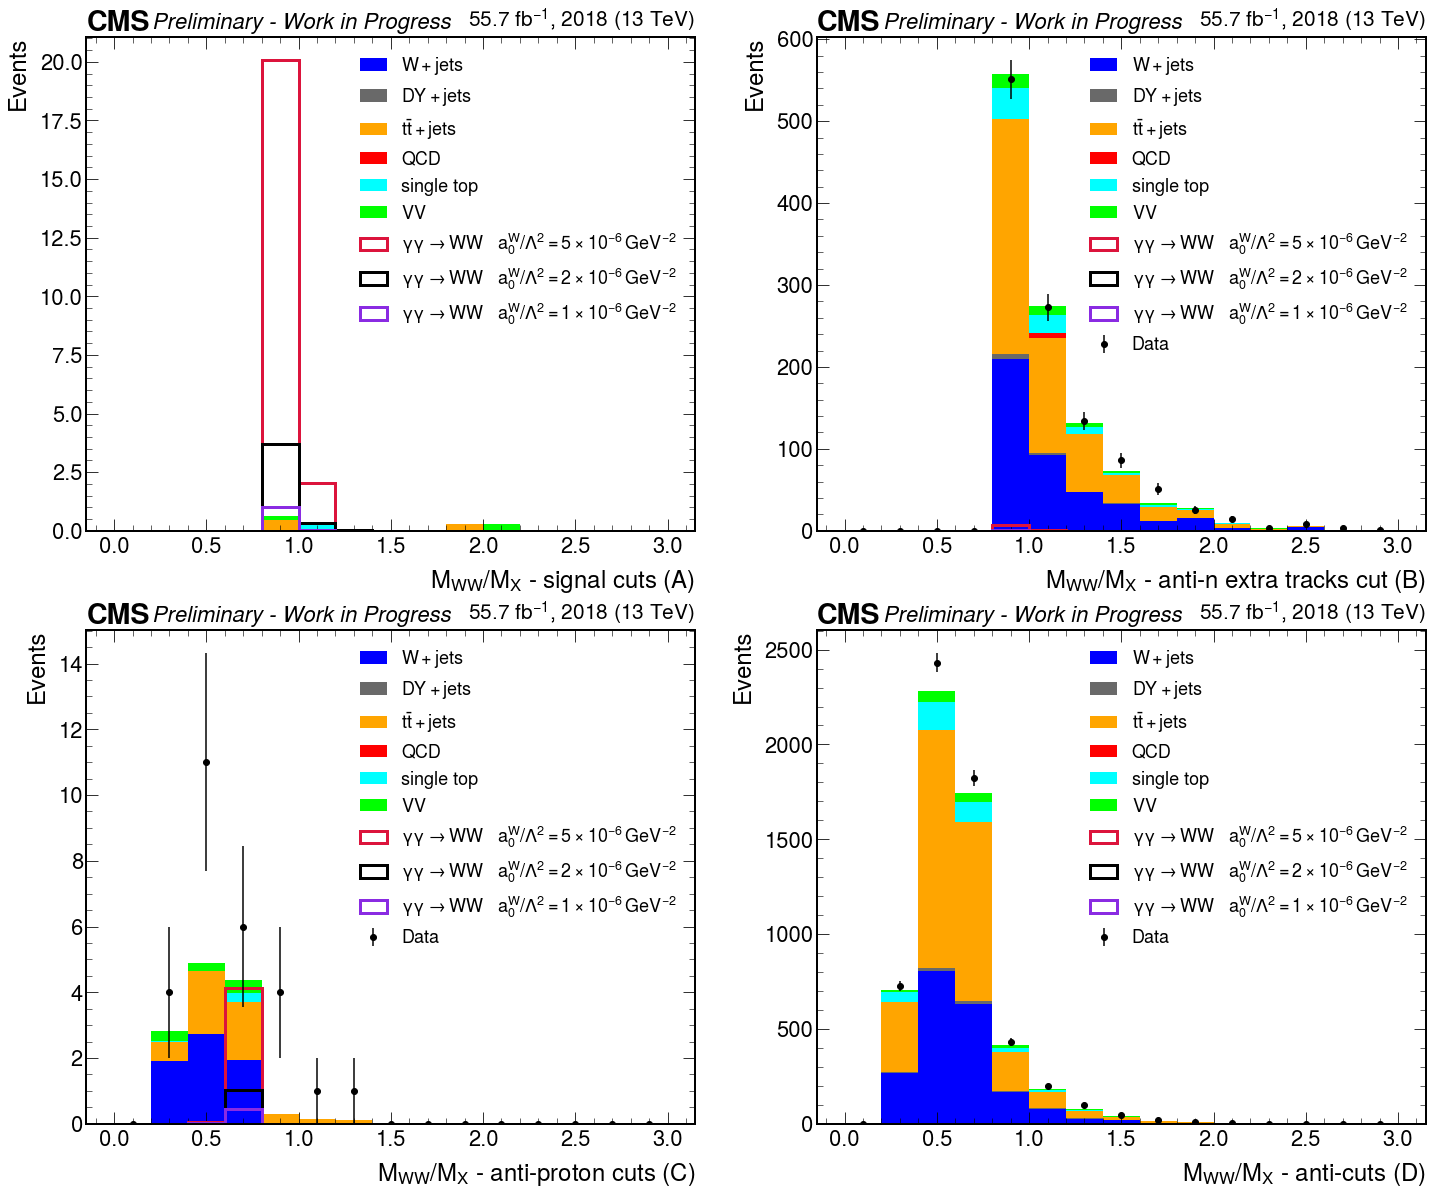

In [34]:
plot_var__ = "R_MWW_MX"
variation__ = "_nom"

res_bkg, res_sig, res_data = plot_sideband( plot_var=plot_var__, variation=variation__, df_bkg_events=df_protons_multiRP_bkg_events, df_data__=df_protons_multiRP_data_events )
n_events_bkg_mskA, err_n_events_bkg_mskA = res_bkg[ 0 ]
n_events_bkg_mskB, err_n_events_bkg_mskB = res_bkg[ 1 ]
n_events_bkg_mskC, err_n_events_bkg_mskC = res_bkg[ 2 ]
n_events_bkg_mskD, err_n_events_bkg_mskD = res_bkg[ 3 ]
n_events_sig_mskA, err_n_events_sig_mskA = res_sig[ 0 ]
n_events_sig_mskB, err_n_events_sig_mskB = res_sig[ 1 ]
n_events_sig_mskC, err_n_events_sig_mskC = res_sig[ 2 ]
n_events_sig_mskD, err_n_events_sig_mskD = res_sig[ 3 ]
n_events_data_mskA, err_n_events_data_mskA = res_data[ 0 ]
n_events_data_mskB, err_n_events_data_mskB = res_data[ 1 ]
n_events_data_mskC, err_n_events_data_mskC = res_data[ 2 ]
n_events_data_mskD, err_n_events_data_mskD = res_data[ 3 ]

In [35]:
sideband_ratio = res_data[2][0]/res_data[3][0]
sideband_ratio

0.004661602209944752

In [36]:
sigma_sideband_ratio = sideband_ratio*(np.sqrt((res_data[2][1]/res_data[2][0])**2 + (res_data[3][1]/res_data[3][0])**2))
sigma_sideband_ratio

0.0008992143540954385

In [37]:
# ntracks_ratio = 0.003161394945044145 +/- 0.0002279216107072979 - muon
# sidebands_ratio = 0.0038816758131441573 +/- 0.0007222067214835958 - muon
# ntracks_ratio = 0.0037902490479681046 +/- 0.00026080823683834637 - electron
# sidebands_ratio = 0.004661602209944752 +/- 0.0008992143540954385 - electron
if lepton_type == "muon":
    df_protons_multiRP_data_events['ntracks_ratio'] = .003161394945044145
if lepton_type == "electron":
    df_protons_multiRP_data_events['ntracks_ratio'] = .0037902490479681046
df_protons_multiRP_data_events['ntracks_ratio']

run     lumiblock  event      slice
315420  894        607660352  0        0.00379
315689  566        636253248  0        0.00379
        601        669445312  0        0.00379
        912        942155456  0        0.00379
316113  21         22611448   0        0.00379
                                        ...   
324970  177        300112576  0        0.00379
        256        453027680  0        0.00379
        327        582200128  0        0.00379
325057  166        233898736  0        0.00379
        171        242674208  0        0.00379
Name: ntracks_ratio, Length: 6978, dtype: float64

In [38]:
df_protons_multiRP_data_events

crossingAngle  betaStar   instLumi  \
run    lumiblock event     slice                                       
315420 894       607660352 0              140.0       0.3   6.274613   
315689 566       636253248 0              145.0       0.3  12.681597   
       601       669445312 0              144.0       0.3  12.428791   
       912       942155456 0              139.0       0.3  10.532442   
316113 21        22611448  0              145.0       0.3  14.523238   
...                                         ...       ...        ...   
324970 177       300112576 0              152.0       0.3  15.271754   
       256       453027680 0              150.0       0.3  14.538785   
       327       582200128 0              148.0       0.3  14.043468   
325057 166       233898736 0              154.0       0.3  16.653351   
       171       242674208 0              154.0       0.3  16.608753   

                                     jet0_pt  jet0_eta  jet0_phi  jet0_energy  \
run    lumiblock event     slice                                                
315420 894       607660352 0      258.122955 -0.151701 -0.278464   281.889465   
315689 566       636253248 0      298.619965 -0.197992  1.619337   323.036804   
       601       669445312 0      234.071930  2.055293 -2.808219   934.243713   
       912       942155456 0      286.378571 -1.798485  0.791238   895.803040   
316113 21        22611448  0      328.659332  1.310705  3.026260   659.845215   
...                                      ...       ...       ...          ...   
324970 177       300112576 0      223.070938  1.354780 -2.376067   468.770477   
       256       453027680 0      241.478012 -2.231910  2.359446  1144.049316   
       327       582200128 0      266.594299  1.260812  1.353572   515.477173   
325057 166       233898736 0      391.919220 -0.288253 -1.681685   422.000427   
       171       242674208 0      258.054443  0.826060  2.375797   365.828156   

                                  jet0_mass  jet0_corrmass  jet0_tau1  ...  \
run    lumiblock event     slice                                       ...   
315420 894       607660352 0      99.471184     108.158211   0.372633  ...   
315689 566       636253248 0      80.917633      87.953377   0.403684  ...   
       601       669445312 0      65.481148      72.851067   0.402492  ...   
       912       942155456 0      86.431564      96.167435   0.389221  ...   
316113 21        22611448  0      63.413235      72.488525   0.165061  ...   
...                                     ...            ...        ...  ...   
324970 177       300112576 0      69.586945      80.467186   0.354163  ...   
       256       453027680 0      80.165199      92.507919   0.457832  ...   
       327       582200128 0      60.998882      70.779312   0.277510  ...   
325057 166       233898736 0      74.646637      81.343063   0.233085  ...   
       171       242674208 0      85.260277      93.221931   0.343124  ...   

                                       MX_nom    YX_nom  R_MWW_MX_nom  \
run    lumiblock event     slice                                        
315420 894       607660352 0       967.723131 -0.150952      0.711129   
315689 566       636253248 0      1305.665508 -0.438442      0.465918   
       601       669445312 0      1145.425931 -0.022969      1.119010   
       912       942155456 0      1047.189325 -0.267798      0.652862   
316113 21        22611448  0      1824.084684 -0.248987      0.549927   
...                                       ...       ...           ...   
324970 177       300112576 0      1795.972750 -0.010185      0.302019   
       256       453027680 0      1444.284059  0.016524      0.731675   
       327       582200128 0      1503.410459 -0.340860      0.386401   
325057 166       233898736 0       783.414695 -0.351177      1.074619   
       171       242674208 0       638.552126 -0.337849      0.814065   

                                  Diff_YWW_YX_nom  jet0_tau21  jet0_tau21_ddt 

/tmp/ipykernel_610/701651650.py:38: RuntimeWarning: invalid value encountered in divide
  ( np.sqrt( sum_errors2 ) / counts_bins_data_ ) ** 2 ) )


Number of data events: 4.36257665421131 +/- 0.32657228384782144


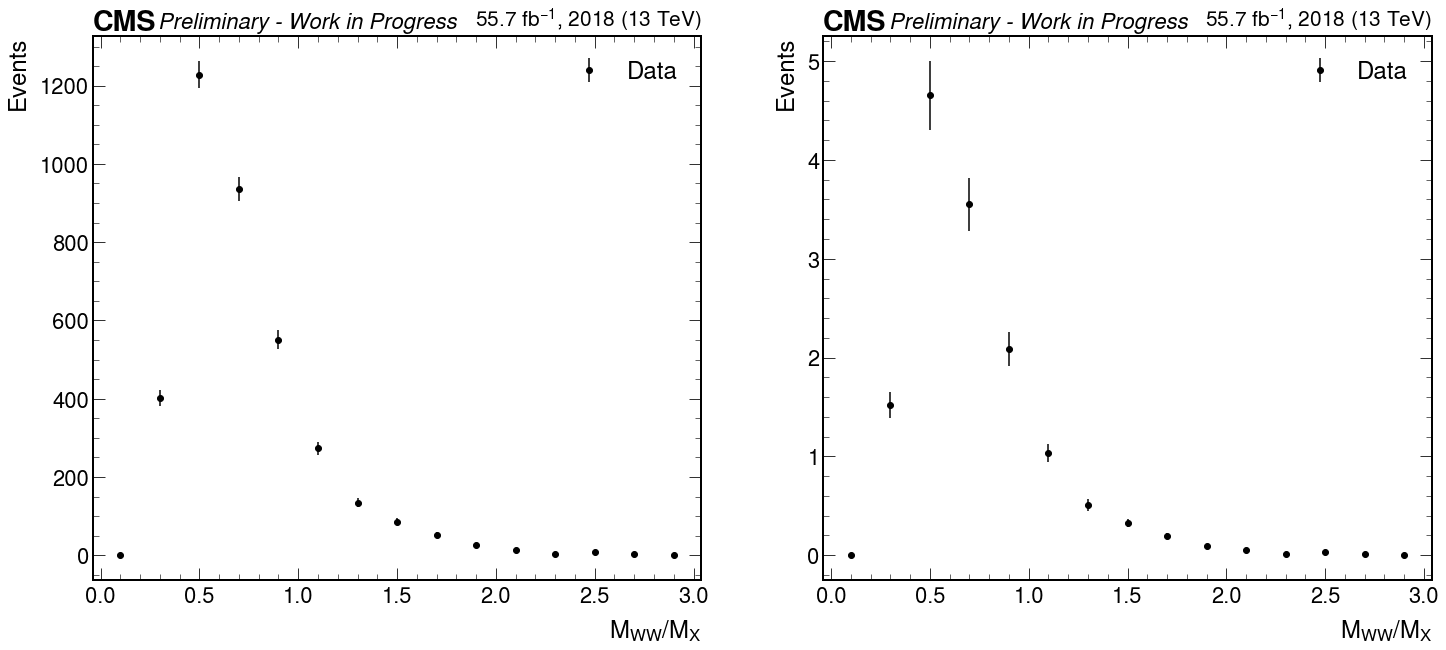

In [39]:
var1__ = ( "pfcand_nextracks" )
var2__ = ( "Diff_YWW_YX" + "_nom" )
var3__ = ( "R_MWW_MX" + "_nom" )

plot_var__ = "R_MWW_MX"
variation__ = "_nom"
x_min =  0.
x_max =  3.

msk_data_cut1 = ( df_protons_multiRP_data_events[ var1__ ] > 4 )
msk_data_cut2 = ( np.abs( df_protons_multiRP_data_events[ var2__ ] ) <= 0.60 )
msk_data_cut3 = ( df_protons_multiRP_data_events[ var3__ ] >= 0.80  )
 
msk_data =  msk_data_cut1 & msk_data_cut2 #& msk_data_cut3

fig, axes = plt.subplots( 1, 2, figsize=(2*12,10) )

counts_bins_data_, bin_edges_ = np.histogram( df_protons_multiRP_data_events[ plot_var__ + variation__ ][ msk_data ], range=[x_min,x_max], bins=15 )
errors_bins_data_ = np.sqrt( counts_bins_data_ )
bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
axes[0].errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
n_events_data_mskB = np.sum( counts_bins_data_ )
err_n_events_data_mskB = np.sqrt( np.sum( counts_bins_data_ ) )
    
axes[0].set_xlabel( r"$ M_{WW} / M_{X} $" )
axes[0].set_ylabel( "Events")
axes[0].legend( loc='best')
mplhep.cms.label('Preliminary - Work in Progress', ax=axes[0], data=True, lumi=55.7, year=2018, loc=0, fontsize=22)

counts_bins_data_, bin_edges_ = np.histogram( df_protons_multiRP_data_events[ plot_var__ + variation__ ][ msk_data ], weights=df_protons_multiRP_data_events['ntracks_ratio'][ msk_data ], range=[x_min,x_max], bins=15 )
sum_errors2, bin_edges_2 = np.histogram( df_protons_multiRP_data_events[ plot_var__ + variation__ ][ msk_data ], weights=df_protons_multiRP_data_events['ntracks_ratio'][ msk_data ]**2, range=[x_min,x_max], bins=15 )
if lepton_type == "muon":
    sigma_ = counts_bins_data_ * ( np.sqrt( ( .0002279216107072979 / .003161394945044145 ) ** 2 + 
                       ( np.sqrt( sum_errors2 ) / counts_bins_data_ ) ** 2 ) )
if lepton_type == "electron":
    sigma_ = counts_bins_data_ * ( np.sqrt( ( .00026080823683834637 / .0037902490479681046 ) ** 2 + 
                       ( np.sqrt( sum_errors2 ) / counts_bins_data_ ) ** 2 ) )
errors_bins_data_ = sigma_
bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[1].errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
n_events_data = np.sum( counts_bins_data_[ bin_centres_ >= 0.8 ] )
if lepton_type == "muon":
    err_n_events_data = np.sum( counts_bins_data_[ bin_centres_ >= 0.8 ] ) * ( np.sqrt( ( .0002279216107072979 / .003161394945044145 ) ** 2 + 
                       ( np.sqrt( np.sum( sum_errors2[ bin_centres_ >= 0.8 ] ) ) / np.sum( counts_bins_data_[ bin_centres_ >= 0.8 ] ) ) ** 2 ) )
if lepton_type == "electron":
    err_n_events_data = np.sum( counts_bins_data_[ bin_centres_ >= 0.8 ] ) * ( np.sqrt( ( .00026080823683834637 / .0037902490479681046 ) ** 2 + 
                       ( np.sqrt( np.sum( sum_errors2[ bin_centres_ >= 0.8 ] ) ) / np.sum( counts_bins_data_[ bin_centres_ >= 0.8 ] ) ) ** 2 ) )
print ( "Number of data events: {} +/- {}".format( n_events_data, err_n_events_data ) )
    
axes[1].set_xlabel( r"$ M_{WW} / M_{X} $" )
axes[1].set_ylabel( "Events" )
axes[1].legend( loc='best')
mplhep.cms.label('Preliminary - Work in Progress', ax=axes[1], data=True, lumi=55.7, year=2018, loc=0, fontsize=22)

if save_figures:
    if lepton_type == 'muon':
        plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-Sideband-Muon_Finn-Method_2018.pdf", bbox_inches='tight' )
        plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-Sideband-Muon_Finn-Method_2018.png", bbox_inches='tight' )
    elif lepton_type == 'electron':
        plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-Sideband-Electron_Finn-Method_2018.pdf", bbox_inches='tight' )
        plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-Sideband-Electron_Finn-Method_2018.png", bbox_inches='tight' )